In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wordcloud
!pip install stanza
!pip install zemberek-python
!pip install jpype1
!pip install pyspellchecker
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 20.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141214 sha256=b896c38ac1e0feeb8b84b6e3453ac4671b6c29a5b89cc797ea2485f14b32ad39
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.8 MB/s eta 0:00:00


In [30]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
import stanza
from spellchecker import SpellChecker
from nltk.corpus import words
import zemberek
from zemberek.morphology import TurkishMorphology
from zemberek.tokenization import TurkishTokenizer
from zemberek.normalization import TurkishSpellChecker
from zemberek.normalization import  TurkishSentenceNormalizer
from zemberek.morphology.analysis.single_analysis import SingleAnalysis
import jpype
import jpype.imports
from jpype.types import JString

# READ DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TwitterProje/data/tweets.csv')
#df = pd.read_csv('../data/tweets.csv')
df.head()

,Date,Tweet
0,08.02.2023,@haluklevent\n @OguzhanUgur\n hepinizden Alla...
1,08.02.2023,Allahım nolur sen onlara dayanma gücü ver #deprem
2,08.02.2023,Replying to \n@haluklevent\n @danlabilic\n and...
3,08.02.2023,Tuğba södekoğlu kovulsun \n@showtv\n #deprem
4,08.02.2023,ARKADAŞIMIZA ULAŞAMIYORUZ\nKahramanmaraş Elbis...


# CHECK DATA

In [ ]:
def checkData(data):
    print("****************SHAPE****************")
    print(data.shape)
    print("****************COLUMNS****************")
    print(data.columns)
    print("****************DTYPES****************")
    print(data.dtypes)
    print("****************HEAD****************")
    print(data.head())
    print("****************Tail****************")
    print(data.tail())
    print("****************NA****************")
    print(data.isnull().sum())
    print("****************INFO****************")
    print(data.info())

checkData(df)

****************SHAPE****************
(945070, 2)
****************COLUMNS****************
Index(['Date', 'Tweet'], dtype='object')
****************DTYPES****************
Date     object
Tweet    object
dtype: object
****************HEAD****************
         Date                                              Tweet
0  08.02.2023  @haluklevent\n @OguzhanUgur\n  hepinizden Alla...
1  08.02.2023  Allahım nolur sen onlara dayanma gücü ver #deprem
2  08.02.2023  Replying to \n@haluklevent\n @danlabilic\n and...
3  08.02.2023       Tuğba södekoğlu kovulsun \n@showtv\n #deprem
4  08.02.2023  ARKADAŞIMIZA ULAŞAMIYORUZ\nKahramanmaraş Elbis...
****************Tail****************
              Date                                              Tweet
945065  10.02.2023  HALA UMUT VAR BELKİ RT YAPTIK BELKİ YAPMADIK A...
945066  10.02.2023  Can can deyu söylerlerdi…Ben can nedir şimdi b...
945067  10.02.2023  Deprem bölgelerinde hırsızlık, yağmacılık yapa...
945068  10.02.2023  Deprem bölgesinden k

# Drop Duplicate & Nan

In [ ]:
df = df.drop_duplicates(subset=["Tweet"], keep="first").reset_index(drop=True)
df = df.dropna(subset=["Tweet"]).reset_index(drop=True)
checkData(df)

****************SHAPE****************
(875904, 2)
****************COLUMNS****************
Index(['Date', 'Tweet'], dtype='object')
****************DTYPES****************
Date     object
Tweet    object
dtype: object
****************HEAD****************
         Date                                              Tweet
0  08.02.2023  @haluklevent\n @OguzhanUgur\n  hepinizden Alla...
1  08.02.2023  Allahım nolur sen onlara dayanma gücü ver #deprem
2  08.02.2023  Replying to \n@haluklevent\n @danlabilic\n and...
3  08.02.2023       Tuğba södekoğlu kovulsun \n@showtv\n #deprem
4  08.02.2023  ARKADAŞIMIZA ULAŞAMIYORUZ\nKahramanmaraş Elbis...
****************Tail****************
              Date                                              Tweet
875899  10.02.2023     OBİLET DEPREM BÖLGELERİNDEN ÜCRETSİZ TAHLİY...
875900  10.02.2023  Anne ve 6 Aylık bebeğin enkaz altından ses gel...
875901  10.02.2023  Can can deyu söylerlerdi…Ben can nedir şimdi b...
875902  10.02.2023  Deprem bölgelerinde 

# Tweets Lower And Conver Str

In [ ]:
df['Tweet'] = df['Tweet'].astype(str)
df['Tweet'] = df['Tweet'].str.lower()

In [ ]:
df['lower'] = df['Tweet'].astype(str).str.lower()
df[['Tweet','lower']]

,Tweet,lower
0,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...
1,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem
2,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...
3,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem
4,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...
...,...,...
875899,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...
875900,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...
875901,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...
875902,"deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa..."


# Count By Tweet Date

In [ ]:
tweet_counts = df.groupby('Date')['Tweet'].count().sort_values(ascending=False)
print("=== Tweet Counts by Date ===")
print(tweet_counts)

=== Tweet Counts by Date ===
Date
06.02.2023    465560
07.02.2023    196001
08.02.2023     97372
09.02.2023     71622
10.02.2023     45349
Name: Tweet, dtype: int64


# Hashtags

In [ ]:
hashtag_counts = df['Tweet'].str.findall(r'#\w+').explode().value_counts()
print("=== Hashtag Counts ===")
print(hashtag_counts)

=== Hashtag Counts ===
Tweet
#deprem                 2509
#hatay                   400
#hatayyardimbekliyor     194
#depremsondakika         185
#afad                    164
                        ... 
#bursa                     1
#gökberkdemirci            1
#erdbeben                  1
#helpturkiye               1
#o                         1
Name: count, Length: 836, dtype: int64


# Word Cloud Hashtags

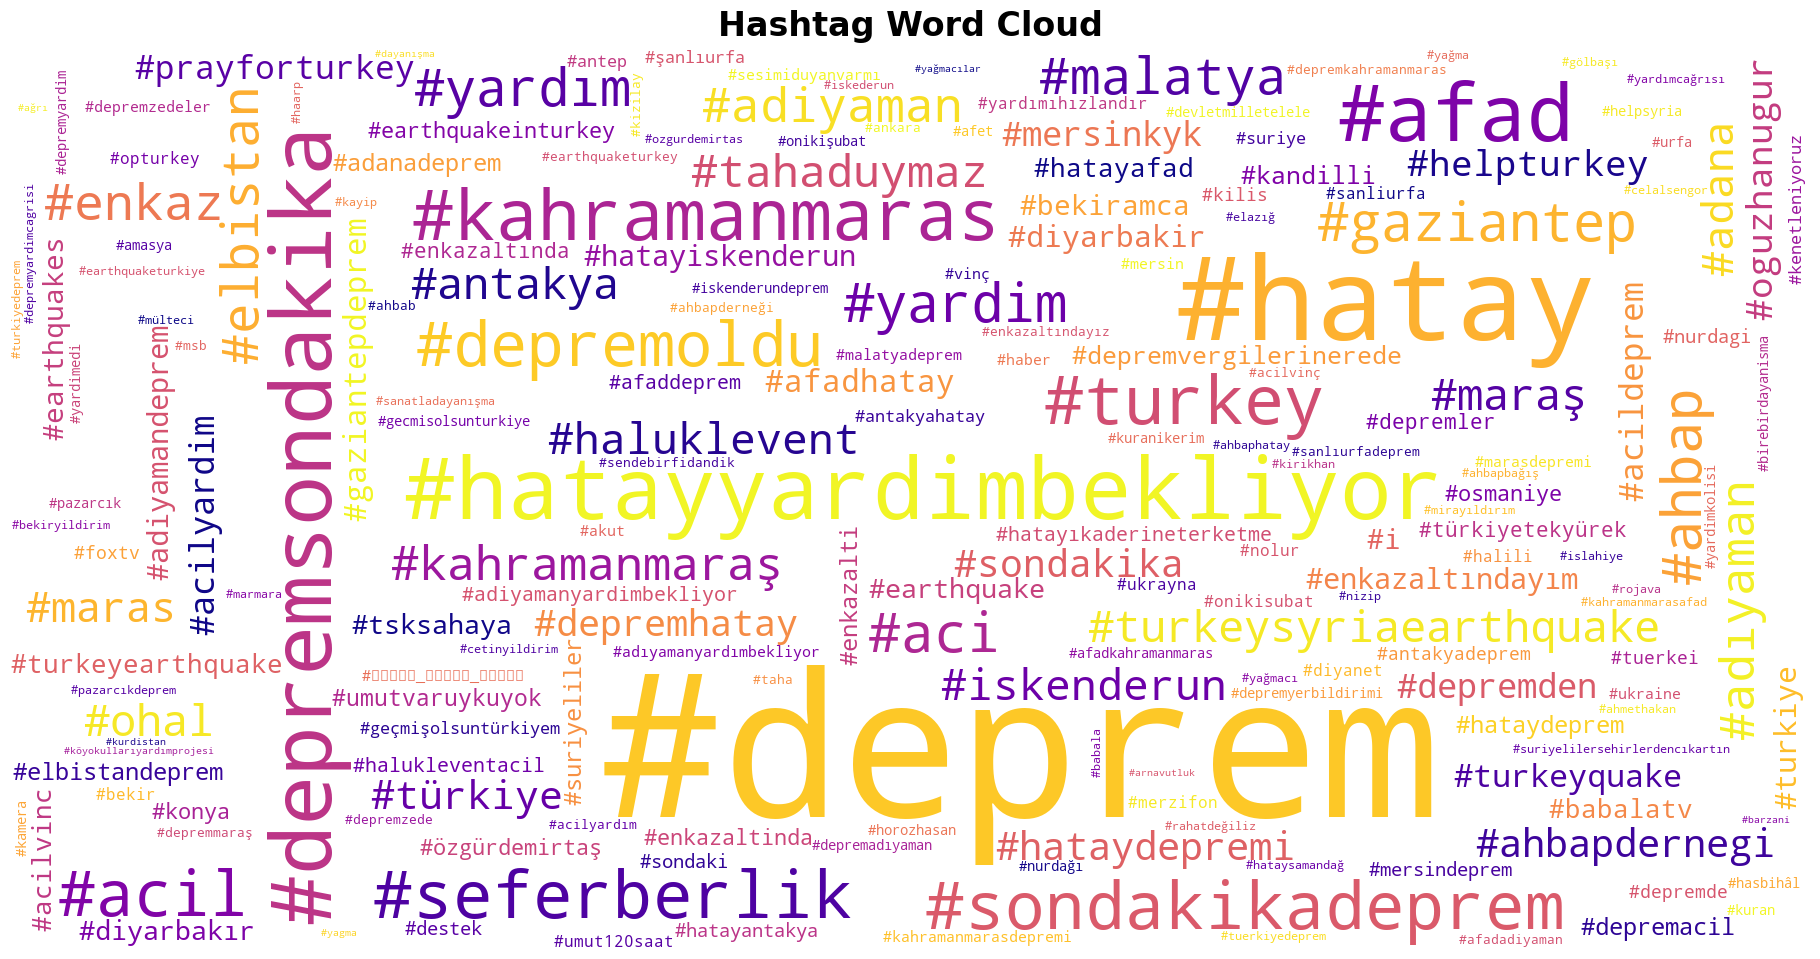

In [ ]:
hashtag_dict = hashtag_counts.to_dict()
wordcloud = WordCloud(
    width=1800,
    height=900,
    background_color='white',
    min_font_size=10,
    max_font_size=200,
    colormap='plasma',
    contour_color='steelblue',
    contour_width=1.5
).generate_from_frequencies(hashtag_dict)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hashtag Word Cloud', fontsize=24, fontweight='bold', pad=10)
plt.tight_layout(pad=0)
plt.show()

# Remove @ mentions and hyperlinks

In [ ]:
def remove_mentions(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    return text

df['content_ment_link'] = df['Tweet'].apply(lambda x: remove_mentions(x))
df['content_ment_link'] = df['content_ment_link'].apply(lambda x: remove_urls(x))
df.head()

,Date,Tweet,lower,content_ment_link
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...
1,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem
2,08.02.2023,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...
3,08.02.2023,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem
4,08.02.2023,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...


In [ ]:
df

,Date,Tweet,lower,content_ment_link
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...
1,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem
2,08.02.2023,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...
3,08.02.2023,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem
4,08.02.2023,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...
...,...,...,...,...
875899,10.02.2023,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...
875900,10.02.2023,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...
875901,10.02.2023,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...
875902,10.02.2023,"deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa..."


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,535 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,539 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,557 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,560 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,575 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,577 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,590 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,594 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,607 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-12-05 19:40:04,610 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Date')):
  _plot_series(series, series_name, i)
  fig.legend(title='Date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

## Removal of Punctuations

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['content_wo_punct'] = df['content_ment_link'].apply(lambda x: remove_punctuation(x))
df['content_wo_punct'] = df['content_wo_punct'].str.replace('\n', ' ', regex=False)
df

,Date,Tweet,lower,content_ment_link,content_wo_punct
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...
1,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem
2,08.02.2023,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...
3,08.02.2023,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem
4,08.02.2023,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...
...,...,...,...,...,...
875899,10.02.2023,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...
875900,10.02.2023,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...
875901,10.02.2023,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...
875902,10.02.2023,"deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...",deprem bölgelerinde hırsızlık yağmacılık yapan...


## Remove Emojies & Numbers

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\u231A-\u231B"
        u"\u23E9-\u23EC"
        u"\u25FD-\u25FE"
        u"\u2614-\u2615"
        u"\u2648-\u2653"
        u"\u26AA-\u26AB"
        u"\u26BD-\u26BE"
        u"\u26C4-\u26C5"
        u"\u26F2-\u26F3"
        u"\u270A-\u270B"
        u"\u2753-\u2755"
        u"\u2795-\u2797"
        u"\u2B1B-\u2B1C"
        u"\U0001F191-\U0001F19A"
        u"\U0001F232-\U0001F236"
        u"\U0001F238-\U0001F23A"
        u"\U0001F250-\U0001F251"
        u"\U0001F300-\U0001F30C"
        u"\U0001F30D-\U0001F30E"
        u"\U0001F313-\U0001F315"
        u"\U0001F316-\U0001F318"
        u"\U0001F31D-\U0001F31E"
        u"\U0001F31F-\U0001F320"
        u"\U0001F32D-\U0001F32F"
        u"\U0001F330-\U0001F331"
        u"\U0001F332-\U0001F333"
        u"\U0001F334-\U0001F335"
        u"\U0001F337-\U0001F34A"
        u"\U0001F34C-\U0001F34F"
        u"\U0001F351-\U0001F37B"
        u"\U0001F37E-\U0001F37F"
        u"\U0001F380-\U0001F393"
        u"\U0001F3A0-\U0001F3C4"
        u"\U0001F3CF-\U0001F3D3"
        u"\U0001F3E0-\U0001F3E3"
        u"\U0001F3E5-\U0001F3F0"
        u"\U0001F3F8-\U0001F407"
        u"\U0001F409-\U0001F40B"
        u"\U0001F40C-\U0001F40E"
        u"\U0001F40F-\U0001F410"
        u"\U0001F411-\U0001F412"
        u"\U0001F417-\U0001F429"
        u"\U0001F42B-\U0001F43E"
        u"\U0001F442-\U0001F464"
        u"\U0001F466-\U0001F46B"
        u"\U0001F46C-\U0001F46D"
        u"\U0001F46E-\U0001F4AC"
        u"\U0001F4AE-\U0001F4B5"
        u"\U0001F4B6-\U0001F4B7"
        u"\U0001F4B8-\U0001F4EB"
        u"\U0001F4EC-\U0001F4ED"
        u"\U0001F4F0-\U0001F4F4"
        u"\U0001F4F6-\U0001F4F7"
        u"\U0001F4F9-\U0001F4FC"
        u"\U0001F4FF-\U0001F502"
        u"\U0001F504-\U0001F507"
        u"\U0001F50A-\U0001F514"
        u"\U0001F516-\U0001F52B"
        u"\U0001F52C-\U0001F52D"
        u"\U0001F52E-\U0001F53D"
        u"\U0001F54B-\U0001F54E"
        u"\U0001F550-\U0001F55B"
        u"\U0001F55C-\U0001F567"
        u"\U0001F595-\U0001F596"
        u"\U0001F5FB-\U0001F5FF"
        u"\U0001F601-\U0001F606"
        u"\U0001F607-\U0001F608"
        u"\U0001F609-\U0001F60D"
        u"\U0001F612-\U0001F614"
        u"\U0001F61C-\U0001F61E"
        u"\U0001F620-\U0001F625"
        u"\U0001F626-\U0001F627"
        u"\U0001F628-\U0001F62B"
        u"\U0001F62E-\U0001F62F"
        u"\U0001F630-\U0001F633"
        u"\U0001F637-\U0001F640"
        u"\U0001F641-\U0001F644"
        u"\U0001F645-\U0001F64F"
        u"\U0001F681-\U0001F682"
        u"\U0001F683-\U0001F685"
        u"\U0001F68A-\U0001F68B"
        u"\U0001F691-\U0001F693"
        u"\U0001F699-\U0001F69A"
        u"\U0001F69B-\U0001F6A1"
        u"\U0001F6A4-\U0001F6A5"
        u"\U0001F6A7-\U0001F6AD"
        u"\U0001F6AE-\U0001F6B1"
        u"\U0001F6B3-\U0001F6B5"
        u"\U0001F6B7-\U0001F6B8"
        u"\U0001F6B9-\U0001F6BE"
        u"\U0001F6C1-\U0001F6C5"
        u"\U0001F6D1-\U0001F6D2"
        u"\U0001F6D6-\U0001F6D7"
        u"\U0001F6DD-\U0001F6DF"
        u"\U0001F6EB-\U0001F6EC"
        u"\U0001F6F4-\U0001F6F6"
        u"\U0001F6F7-\U0001F6F8"
        u"\U0001F6FB-\U0001F6FC"
        u"\U0001F7E0-\U0001F7EB"
        u"\U0001F90D-\U0001F90F"
        u"\U0001F910-\U0001F918"
        u"\U0001F919-\U0001F91E"
        u"\U0001F920-\U0001F927"
        u"\U0001F928-\U0001F92F"
        u"\U0001F931-\U0001F932"
        u"\U0001F933-\U0001F93A"
        u"\U0001F93C-\U0001F93E"
        u"\U0001F940-\U0001F945"
        u"\U0001F947-\U0001F94B"
        u"\U0001F94D-\U0001F94F"
        u"\U0001F950-\U0001F95E"
        u"\U0001F95F-\U0001F96B"
        u"\U0001F96C-\U0001F970"
        u"\U0001F973-\U0001F976"
        u"\U0001F977-\U0001F978"
        u"\U0001F97C-\U0001F97F"
        u"\U0001F980-\U0001F984"
        u"\U0001F985-\U0001F991"
        u"\U0001F992-\U0001F997"
        u"\U0001F998-\U0001F9A2"
        u"\U0001F9A3-\U0001F9A4"
        u"\U0001F9A5-\U0001F9AA"
        u"\U0001F9AB-\U0001F9AD"
        u"\U0001F9AE-\U0001F9AF"
        u"\U0001F9B0-\U0001F9B9"
        u"\U0001F9BA-\U0001F9BF"
        u"\U0001F9C1-\U0001F9C2"
        u"\U0001F9C3-\U0001F9CA"
        u"\U0001F9CD-\U0001F9CF"
        u"\U0001F9D0-\U0001F9E6"
        u"\U0001F9E7-\U0001F9FF"
        u"\U0001FA70-\U0001FA73"
        u"\U0001FA78-\U0001FA7A"
        u"\U0001FA7B-\U0001FA7C"
        u"\U0001FA80-\U0001FA82"
        u"\U0001FA83-\U0001FA86"
        u"\U0001FA90-\U0001FA95"
        u"\U0001FA96-\U0001FAA8"
        u"\U0001FAA9-\U0001FAAC"
        u"\U0001FAB0-\U0001FAB6"
        u"\U0001FAB7-\U0001FABA"
        u"\U0001FAC0-\U0001FAC2"
        u"\U0001FAC3-\U0001FAC5"
        u"\U0001FAD0-\U0001FAD6"
        u"\U0001FAD7-\U0001FAD9"
        u"\U0001FAE0-\U0001FAE7"
        u"\U0001FAF0-\U0001FAF6"
        u"\u23F0"
        u"\u23F3"
        u"\u267F"
        u"\u2693"
        u"\u26A1"
        u"\u26CE"
        u"\u26D4"
        u"\u26EA"
        u"\u26F5"
        u"\u26FA"
        u"\u26FD"
        u"\u2705"
        u"\u2728"
        u"\u274C"
        u"\u274E"
        u"\u2757"
        u"\u27B0"
        u"\u27BF"
        u"\u2B50"
        u"\u2B55"
        u"\U0001F004"
        u"\U0001F0CF"
        u"\U0001F18E"
        u"\U0001F201"
        u"\U0001F21A"
        u"\U0001F22F"
        u"\U0001F30F"
        u"\U0001F310"
        u"\U0001F311"
        u"\U0001F312"
        u"\U0001F319"
        u"\U0001F31A"
        u"\U0001F31B"
        u"\U0001F31C"
        u"\U0001F34B"
        u"\U0001F350"
        u"\U0001F37C"
        u"\U0001F3C5"
        u"\U0001F3C6"
        u"\U0001F3C7"
        u"\U0001F3C8"
        u"\U0001F3C9"
        u"\U0001F3CA"
        u"\U0001F3E4"
        u"\U0001F3F4"
        u"\U0001F408"
        u"\U0001F413"
        u"\U0001F414"
        u"\U0001F415"
        u"\U0001F416"
        u"\U0001F42A"
        u"\U0001F440"
        u"\U0001F465"
        u"\U0001F4AD"
        u"\U0001F4EE"
        u"\U0001F4EF"
        u"\U0001F4F5"
        u"\U0001F4F8"
        u"\U0001F503"
        u"\U0001F508"
        u"\U0001F509"
        u"\U0001F515"
        u"\U0001F57A"
        u"\U0001F5A4"
        u"\U0001F600"
        u"\U0001F60E"
        u"\U0001F60F"
        u"\U0001F610"
        u"\U0001F611"
        u"\U0001F615"
        u"\U0001F616"
        u"\U0001F617"
        u"\U0001F618"
        u"\U0001F619"
        u"\U0001F61A"
        u"\U0001F61B"
        u"\U0001F61F"
        u"\U0001F62C"
        u"\U0001F62D"
        u"\U0001F634"
        u"\U0001F635"
        u"\U0001F636"
        u"\U0001F680"
        u"\U0001F686"
        u"\U0001F687"
        u"\U0001F688"
        u"\U0001F689"
        u"\U0001F68C"
        u"\U0001F68D"
        u"\U0001F68E"
        u"\U0001F68F"
        u"\U0001F690"
        u"\U0001F694"
        u"\U0001F695"
        u"\U0001F696"
        u"\U0001F697"
        u"\U0001F698"
        u"\U0001F6A2"
        u"\U0001F6A3"
        u"\U0001F6A6"
        u"\U0001F6B2"
        u"\U0001F6B6"
        u"\U0001F6BF"
        u"\U0001F6C0"
        u"\U0001F6CC"
        u"\U0001F6D0"
        u"\U0001F6D5"
        u"\U0001F6F9"
        u"\U0001F6FA"
        u"\U0001F7F0"
        u"\U0001F90C"
        u"\U0001F91F"
        u"\U0001F930"
        u"\U0001F93F"
        u"\U0001F94C"
        u"\U0001F971"
        u"\U0001F972"
        u"\U0001F979"
        u"\U0001F97A"
        u"\U0001F97B"
        u"\U0001F9C0"
        u"\U0001F9CB"
        u"\U0001F9CC"
        u"\U0001FA74"
        u"\u00A9"
        u"\uFE0F"
        u"\u00AE"
        u"\uFE0F"
        u"\u203C"
        u"\uFE0F"
        u"\u2049"
        u"\uFE0F"
        u"\u2122"
        u"\uFE0F"
        u"\u2139"
        u"\uFE0F"
        u"\u2194"
        u"\uFE0F"
        u"\u2195"
        u"\uFE0F"
        u"\u2196"
        u"\uFE0F"
        u"\u2197"
        u"\uFE0F"
        u"\u2198"
        u"\uFE0F"
        u"\u2199"
        u"\uFE0F"
        u"\u21A9"
        u"\uFE0F"
        u"\u21AA"
        u"\uFE0F"
        u"\u2328"
        u"\uFE0F"
        u"\u23CF"
        u"\uFE0F"
        u"\u23ED"
        u"\uFE0F"
        u"\u23EE"
        u"\uFE0F"
        u"\u23EF"
        u"\uFE0F"
        u"\u23F1"
        u"\uFE0F"
        u"\u23F2"
        u"\uFE0F"
        u"\u23F8"
        u"\uFE0F"
        u"\u23F9"
        u"\uFE0F"
        u"\u23FA"
        u"\uFE0F"
        u"\u24C2"
        u"\uFE0F"
        u"\u25AA"
        u"\uFE0F"
        u"\u25AB"
        u"\uFE0F"
        u"\u25B6"
        u"\uFE0F"
        u"\u25C0"
        u"\uFE0F"
        u"\u25FB"
        u"\uFE0F"
        u"\u25FC"
        u"\uFE0F"
        u"\u2600"
        u"\uFE0F"
        u"\u2601"
        u"\uFE0F"
        u"\u2602"
        u"\uFE0F"
        u"\u2603"
        u"\uFE0F"
        u"\u2604"
        u"\uFE0F"
        u"\u260E"
        u"\uFE0F"
        u"\u2611"
        u"\uFE0F"
        u"\u2618"
        u"\uFE0F"
        u"\u261D"
        u"\uFE0F"
        u"\u2620"
        u"\uFE0F"
        u"\u2622"
        u"\uFE0F"
        u"\u2623"
        u"\uFE0F"
        u"\u2626"
        u"\uFE0F"
        u"\u262A"
        u"\uFE0F"
        u"\u262E"
        u"\uFE0F"
        u"\u262F"
        u"\uFE0F"
        u"\u2638"
        u"\uFE0F"
        u"\u2639"
        u"\uFE0F"
        u"\u263A"
        u"\uFE0F"
        u"\u2640"
        u"\uFE0F"
        u"\u2642"
        u"\uFE0F"
        u"\u265F"
        u"\uFE0F"
        u"\u2660"
        u"\uFE0F"
        u"\u2663"
        u"\uFE0F"
        u"\u2665"
        u"\uFE0F"
        u"\u2666"
        u"\uFE0F"
        u"\u2668"
        u"\uFE0F"
        u"\u267B"
        u"\uFE0F"
        u"\u267E"
        u"\uFE0F"
        u"\u2692"
        u"\uFE0F"
        u"\u2694"
        u"\uFE0F"
        u"\u2695"
        u"\uFE0F"
        u"\u2696"
        u"\uFE0F"
        u"\u2697"
        u"\uFE0F"
        u"\u2699"
        u"\uFE0F"
        u"\u269B"
        u"\uFE0F"
        u"\u269C"
        u"\uFE0F"
        u"\u26A0"
        u"\uFE0F"
        u"\u26A7"
        u"\uFE0F"
        u"\u26B0"
        u"\uFE0F"
        u"\u26B1"
        u"\uFE0F"
        u"\u26C8"
        u"\uFE0F"
        u"\u26CF"
        u"\uFE0F"
        u"\u26D1"
        u"\uFE0F"
        u"\u26D3"
        u"\uFE0F"
        u"\u26E9"
        u"\uFE0F"
        u"\u26F0"
        u"\uFE0F"
        u"\u26F1"
        u"\uFE0F"
        u"\u26F4"
        u"\uFE0F"
        u"\u26F7"
        u"\uFE0F"
        u"\u26F8"
        u"\uFE0F"
        u"\u26F9"
        u"\uFE0F"
        u"\u2702"
        u"\uFE0F"
        u"\u2708"
        u"\uFE0F"
        u"\u2709"
        u"\uFE0F"
        u"\u270C"
        u"\uFE0F"
        u"\u270D"
        u"\uFE0F"
        u"\u270F"
        u"\uFE0F"
        u"\u2712"
        u"\uFE0F"
        u"\u2714"
        u"\uFE0F"
        u"\u2716"
        u"\uFE0F"
        u"\u271D"
        u"\uFE0F"
        u"\u2721"
        u"\uFE0F"
        u"\u2733"
        u"\uFE0F"
        u"\u2734"
        u"\uFE0F"
        u"\u2744"
        u"\uFE0F"
        u"\u2747"
        u"\uFE0F"
        u"\u2763"
        u"\uFE0F"
        u"\u2764"
        u"\uFE0F"
        u"\u27A1"
        u"\uFE0F"
        u"\u2934"
        u"\uFE0F"
        u"\u2935"
        u"\uFE0F"
        u"\u2B05"
        u"\uFE0F"
        u"\u2B06"
        u"\uFE0F"
        u"\u2B07"
        u"\uFE0F"
        u"\u3030"
        u"\uFE0F"
        u"\u303D"
        u"\uFE0F"
        u"\u3297"
        u"\uFE0F"
        u"\u3299"
        u"\uFE0F"
        u"\U0001F170"
        u"\uFE0F"
        u"\U0001F171"
        u"\uFE0F"
        u"\U0001F17E"
        u"\uFE0F"
        u"\U0001F17F"
        u"\uFE0F"
        u"\U0001F202"
        u"\uFE0F"
        u"\U0001F237"
        u"\uFE0F"
        u"\U0001F321"
        u"\uFE0F"
        u"\U0001F324"
        u"\uFE0F"
        u"\U0001F325"
        u"\uFE0F"
        u"\U0001F326"
        u"\uFE0F"
        u"\U0001F327"
        u"\uFE0F"
        u"\U0001F328"
        u"\uFE0F"
        u"\U0001F329"
        u"\uFE0F"
        u"\U0001F32A"
        u"\uFE0F"
        u"\U0001F32B"
        u"\uFE0F"
        u"\U0001F32C"
        u"\uFE0F"
        u"\U0001F336"
        u"\uFE0F"
        u"\U0001F37D"
        u"\uFE0F"
        u"\U0001F396"
        u"\uFE0F"
        u"\U0001F397"
        u"\uFE0F"
        u"\U0001F399"
        u"\uFE0F"
        u"\U0001F39A"
        u"\uFE0F"
        u"\U0001F39B"
        u"\uFE0F"
        u"\U0001F39E"
        u"\uFE0F"
        u"\U0001F39F"
        u"\uFE0F"
        u"\U0001F3CB"
        u"\uFE0F"
        u"\U0001F3CC"
        u"\uFE0F"
        u"\U0001F3CD"
        u"\uFE0F"
        u"\U0001F3CE"
        u"\uFE0F"
        u"\U0001F3D4"
        u"\uFE0F"
        u"\U0001F3D5"
        u"\uFE0F"
        u"\U0001F3D6"
        u"\uFE0F"
        u"\U0001F3D7"
        u"\uFE0F"
        u"\U0001F3D8"
        u"\uFE0F"
        u"\U0001F3D9"
        u"\uFE0F"
        u"\U0001F3DA"
        u"\uFE0F"
        u"\U0001F3DB"
        u"\uFE0F"
        u"\U0001F3DC"
        u"\uFE0F"
        u"\U0001F3DD"
        u"\uFE0F"
        u"\U0001F3DE"
        u"\uFE0F"
        u"\U0001F3DF"
        u"\uFE0F"
        u"\U0001F3F3"
        u"\uFE0F"
        u"\U0001F3F5"
        u"\uFE0F"
        u"\U0001F3F7"
        u"\uFE0F"
        u"\U0001F43F"
        u"\uFE0F"
        u"\U0001F441"
        u"\uFE0F"
        u"\U0001F4FD"
        u"\uFE0F"
        u"\U0001F549"
        u"\uFE0F"
        u"\U0001F54A"
        u"\uFE0F"
        u"\U0001F56F"
        u"\uFE0F"
        u"\U0001F570"
        u"\uFE0F"
        u"\U0001F573"
        u"\uFE0F"
        u"\U0001F574"
        u"\uFE0F"
        u"\U0001F575"
        u"\uFE0F"
        u"\U0001F576"
        u"\uFE0F"
        u"\U0001F577"
        u"\uFE0F"
        u"\U0001F578"
        u"\uFE0F"
        u"\U0001F579"
        u"\uFE0F"
        u"\U0001F587"
        u"\uFE0F"
        u"\U0001F58A"
        u"\uFE0F"
        u"\U0001F58B"
        u"\uFE0F"
        u"\U0001F58C"
        u"\uFE0F"
        u"\U0001F58D"
        u"\uFE0F"
        u"\U0001F590"
        u"\uFE0F"
        u"\U0001F5A5"
        u"\uFE0F"
        u"\U0001F5A8"
        u"\uFE0F"
        u"\U0001F5B1"
        u"\uFE0F"
        u"\U0001F5B2"
        u"\uFE0F"
        u"\U0001F5BC"
        u"\uFE0F"
        u"\U0001F5C2"
        u"\uFE0F"
        u"\U0001F5C3"
        u"\uFE0F"
        u"\U0001F5C4"
        u"\uFE0F"
        u"\U0001F5D1"
        u"\uFE0F"
        u"\U0001F5D2"
        u"\uFE0F"
        u"\U0001F5D3"
        u"\uFE0F"
        u"\U0001F5DC"
        u"\uFE0F"
        u"\U0001F5DD"
        u"\uFE0F"
        u"\U0001F5DE"
        u"\uFE0F"
        u"\U0001F5E1"
        u"\uFE0F"
        u"\U0001F5E3"
        u"\uFE0F"
        u"\U0001F5E8"
        u"\uFE0F"
        u"\U0001F5EF"
        u"\uFE0F"
        u"\U0001F5F3"
        u"\uFE0F"
        u"\U0001F5FA"
        u"\uFE0F"
        u"\U0001F6CB"
        u"\uFE0F"
        u"\U0001F6CD"
        u"\uFE0F"
        u"\U0001F6CE"
        u"\uFE0F"
        u"\U0001F6CF"
        u"\uFE0F"
        u"\U0001F6E0"
        u"\uFE0F"
        u"\U0001F6E1"
        u"\uFE0F"
        u"\U0001F6E2"
        u"\uFE0F"
        u"\U0001F6E3"
        u"\uFE0F"
        u"\U0001F6E4"
        u"\uFE0F"
        u"\U0001F6E5"
        u"\uFE0F"
        u"\U0001F6E9"
        u"\uFE0F"
        u"\U0001F6F0"
        u"\uFE0F"
        u"\U0001F6F3"
        u"\uFE0F"
        u"\u0023"
        u"\uFE0F"
        u"\u20E3"
        u"\u002A"
        u"\uFE0F"
        u"\u20E3"
        u"\u0030"
        u"\uFE0F"
        u"\u20E3"
        u"\u0031"
        u"\uFE0F"
        u"\u20E3"
        u"\u0032"
        u"\uFE0F"
        u"\u20E3"
        u"\u0033"
        u"\uFE0F"
        u"\u20E3"
        u"\u0034"
        u"\uFE0F"
        u"\u20E3"
        u"\u0035"
        u"\uFE0F"
        u"\u20E3"
        u"\u0036"
        u"\uFE0F"
        u"\u20E3"
        u"\u0037"
        u"\uFE0F"
        u"\u20E3"
        u"\u0038"
        u"\uFE0F"
        u"\u20E3"
        u"\u0039"
        u"\uFE0F"
        u"\u20E3"
        u"\U0001F1E6"
        u"\U0001F1E8"
        u"\U0001F1E6"
        u"\U0001F1E9"
        u"\U0001F1E6"
        u"\U0001F1EA"
        u"\U0001F1E6"
        u"\U0001F1EB"
        u"\U0001F1E6"
        u"\U0001F1EC"
        u"\U0001F1E6"
        u"\U0001F1EE"
        u"\U0001F1E6"
        u"\U0001F1F1"
        u"\U0001F1E6"
        u"\U0001F1F2"
        u"\U0001F1E6"
        u"\U0001F1F4"
        u"\U0001F1E6"
        u"\U0001F1F6"
        u"\U0001F1E6"
        u"\U0001F1F7"
        u"\U0001F1E6"
        u"\U0001F1F8"
        u"\U0001F1E6"
        u"\U0001F1F9"
        u"\U0001F1E6"
        u"\U0001F1FA"
        u"\U0001F1E6"
        u"\U0001F1FC"
        u"\U0001F1E6"
        u"\U0001F1FD"
        u"\U0001F1E6"
        u"\U0001F1FF"
        u"\U0001F1E7"
        u"\U0001F1E6"
        u"\U0001F1E7"
        u"\U0001F1E7"
        u"\U0001F1E7"
        u"\U0001F1E9"
        u"\U0001F1E7"
        u"\U0001F1EA"
        u"\U0001F1E7"
        u"\U0001F1EB"
        u"\U0001F1E7"
        u"\U0001F1EC"
        u"\U0001F1E7"
        u"\U0001F1ED"
        u"\U0001F1E7"
        u"\U0001F1EE"
        u"\U0001F1E7"
        u"\U0001F1EF"
        u"\U0001F1E7"
        u"\U0001F1F1"
        u"\U0001F1E7"
        u"\U0001F1F2"
        u"\U0001F1E7"
        u"\U0001F1F3"
        u"\U0001F1E7"
        u"\U0001F1F4"
        u"\U0001F1E7"
        u"\U0001F1F6"
        u"\U0001F1E7"
        u"\U0001F1F7"
        u"\U0001F1E7"
        u"\U0001F1F8"
        u"\U0001F1E7"
        u"\U0001F1F9"
        u"\U0001F1E7"
        u"\U0001F1FB"
        u"\U0001F1E7"
        u"\U0001F1FC"
        u"\U0001F1E7"
        u"\U0001F1FE"
        u"\U0001F1E7"
        u"\U0001F1FF"
        u"\U0001F1E8"
        u"\U0001F1E6"
        u"\U0001F1E8"
        u"\U0001F1E8"
        u"\U0001F1E8"
        u"\U0001F1E9"
        u"\U0001F1E8"
        u"\U0001F1EB"
        u"\U0001F1E8"
        u"\U0001F1EC"
        u"\U0001F1E8"
        u"\U0001F1ED"
        u"\U0001F1E8"
        u"\U0001F1EE"
        u"\U0001F1E8"
        u"\U0001F1F0"
        u"\U0001F1E8"
        u"\U0001F1F1"
        u"\U0001F1E8"
        u"\U0001F1F2"
        u"\U0001F1E8"
        u"\U0001F1F3"
        u"\U0001F1E8"
        u"\U0001F1F4"
        u"\U0001F1E8"
        u"\U0001F1F5"
        u"\U0001F1E8"
        u"\U0001F1F7"
        u"\U0001F1E8"
        u"\U0001F1FA"
        u"\U0001F1E8"
        u"\U0001F1FB"
        u"\U0001F1E8"
        u"\U0001F1FC"
        u"\U0001F1E8"
        u"\U0001F1FD"
        u"\U0001F1E8"
        u"\U0001F1FE"
        u"\U0001F1E8"
        u"\U0001F1FF"
        u"\U0001F1E9"
        u"\U0001F1EA"
        u"\U0001F1E9"
        u"\U0001F1EC"
        u"\U0001F1E9"
        u"\U0001F1EF"
        u"\U0001F1E9"
        u"\U0001F1F0"
        u"\U0001F1E9"
        u"\U0001F1F2"
        u"\U0001F1E9"
        u"\U0001F1F4"
        u"\U0001F1E9"
        u"\U0001F1FF"
        u"\U0001F1EA"
        u"\U0001F1E6"
        u"\U0001F1EA"
        u"\U0001F1E8"
        u"\U0001F1EA"
        u"\U0001F1EA"
        u"\U0001F1EA"
        u"\U0001F1EC"
        u"\U0001F1EA"
        u"\U0001F1ED"
        u"\U0001F1EA"
        u"\U0001F1F7"
        u"\U0001F1EA"
        u"\U0001F1F8"
        u"\U0001F1EA"
        u"\U0001F1F9"
        u"\U0001F1EA"
        u"\U0001F1FA"
        u"\U0001F1EB"
        u"\U0001F1EE"
        u"\U0001F1EB"
        u"\U0001F1EF"
        u"\U0001F1EB"
        u"\U0001F1F0"
        u"\U0001F1EB"
        u"\U0001F1F2"
        u"\U0001F1EB"
        u"\U0001F1F4"
        u"\U0001F1EB"
        u"\U0001F1F7"
        u"\U0001F1EC"
        u"\U0001F1E6"
        u"\U0001F1EC"
        u"\U0001F1E7"
        u"\U0001F1EC"
        u"\U0001F1E9"
        u"\U0001F1EC"
        u"\U0001F1EA"
        u"\U0001F1EC"
        u"\U0001F1EB"
        u"\U0001F1EC"
        u"\U0001F1EC"
        u"\U0001F1EC"
        u"\U0001F1ED"
        u"\U0001F1EC"
        u"\U0001F1EE"
        u"\U0001F1EC"
        u"\U0001F1F1"
        u"\U0001F1EC"
        u"\U0001F1F2"
        u"\U0001F1EC"
        u"\U0001F1F3"
        u"\U0001F1EC"
        u"\U0001F1F5"
        u"\U0001F1EC"
        u"\U0001F1F6"
        u"\U0001F1EC"
        u"\U0001F1F7"
        u"\U0001F1EC"
        u"\U0001F1F8"
        u"\U0001F1EC"
        u"\U0001F1F9"
        u"\U0001F1EC"
        u"\U0001F1FA"
        u"\U0001F1EC"
        u"\U0001F1FC"
        u"\U0001F1EC"
        u"\U0001F1FE"
        u"\U0001F1ED"
        u"\U0001F1F0"
        u"\U0001F1ED"
        u"\U0001F1F2"
        u"\U0001F1ED"
        u"\U0001F1F3"
        u"\U0001F1ED"
        u"\U0001F1F7"
        u"\U0001F1ED"
        u"\U0001F1F9"
        u"\U0001F1ED"
        u"\U0001F1FA"
        u"\U0001F1EE"
        u"\U0001F1E8"
        u"\U0001F1EE"
        u"\U0001F1E9"
        u"\U0001F1EE"
        u"\U0001F1EA"
        u"\U0001F1EE"
        u"\U0001F1F1"
        u"\U0001F1EE"
        u"\U0001F1F2"
        u"\U0001F1EE"
        u"\U0001F1F3"
        u"\U0001F1EE"
        u"\U0001F1F4"
        u"\U0001F1EE"
        u"\U0001F1F6"
        u"\U0001F1EE"
        u"\U0001F1F7"
        u"\U0001F1EE"
        u"\U0001F1F8"
        u"\U0001F1EE"
        u"\U0001F1F9"
        u"\U0001F1EF"
        u"\U0001F1EA"
        u"\U0001F1EF"
        u"\U0001F1F2"
        u"\U0001F1EF"
        u"\U0001F1F4"
        u"\U0001F1EF"
        u"\U0001F1F5"
        u"\U0001F1F0"
        u"\U0001F1EA"
        u"\U0001F1F0"
        u"\U0001F1EC"
        u"\U0001F1F0"
        u"\U0001F1ED"
        u"\U0001F1F0"
        u"\U0001F1EE"
        u"\U0001F1F0"
        u"\U0001F1F2"
        u"\U0001F1F0"
        u"\U0001F1F3"
        u"\U0001F1F0"
        u"\U0001F1F5"
        u"\U0001F1F0"
        u"\U0001F1F7"
        u"\U0001F1F0"
        u"\U0001F1FC"
        u"\U0001F1F0"
        u"\U0001F1FE"
        u"\U0001F1F0"
        u"\U0001F1FF"
        u"\U0001F1F1"
        u"\U0001F1E6"
        u"\U0001F1F1"
        u"\U0001F1E7"
        u"\U0001F1F1"
        u"\U0001F1E8"
        u"\U0001F1F1"
        u"\U0001F1EE"
        u"\U0001F1F1"
        u"\U0001F1F0"
        u"\U0001F1F1"
        u"\U0001F1F7"
        u"\U0001F1F1"
        u"\U0001F1F8"
        u"\U0001F1F1"
        u"\U0001F1F9"
        u"\U0001F1F1"
        u"\U0001F1FA"
        u"\U0001F1F1"
        u"\U0001F1FB"
        u"\U0001F1F1"
        u"\U0001F1FE"
        u"\U0001F1F2"
        u"\U0001F1E6"
        u"\U0001F1F2"
        u"\U0001F1E8"
        u"\U0001F1F2"
        u"\U0001F1E9"
        u"\U0001F1F2"
        u"\U0001F1EA"
        u"\U0001F1F2"
        u"\U0001F1EB"
        u"\U0001F1F2"
        u"\U0001F1EC"
        u"\U0001F1F2"
        u"\U0001F1ED"
        u"\U0001F1F2"
        u"\U0001F1F0"
        u"\U0001F1F2"
        u"\U0001F1F1"
        u"\U0001F1F2"
        u"\U0001F1F2"
        u"\U0001F1F2"
        u"\U0001F1F3"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F1F2"
        u"\U0001F1F5"
        u"\U0001F1F2"
        u"\U0001F1F6"
        u"\U0001F1F2"
        u"\U0001F1F7"
        u"\U0001F1F2"
        u"\U0001F1F8"
        u"\U0001F1F2"
        u"\U0001F1F9"
        u"\U0001F1F2"
        u"\U0001F1FA"
        u"\U0001F1F2"
        u"\U0001F1FB"
        u"\U0001F1F2"
        u"\U0001F1FC"
        u"\U0001F1F2"
        u"\U0001F1FD"
        u"\U0001F1F2"
        u"\U0001F1FE"
        u"\U0001F1F2"
        u"\U0001F1FF"
        u"\U0001F1F3"
        u"\U0001F1E6"
        u"\U0001F1F3"
        u"\U0001F1E8"
        u"\U0001F1F3"
        u"\U0001F1EA"
        u"\U0001F1F3"
        u"\U0001F1EB"
        u"\U0001F1F3"
        u"\U0001F1EC"
        u"\U0001F1F3"
        u"\U0001F1EE"
        u"\U0001F1F3"
        u"\U0001F1F1"
        u"\U0001F1F3"
        u"\U0001F1F4"
        u"\U0001F1F3"
        u"\U0001F1F5"
        u"\U0001F1F3"
        u"\U0001F1F7"
        u"\U0001F1F3"
        u"\U0001F1FA"
        u"\U0001F1F3"
        u"\U0001F1FF"
        u"\U0001F1F4"
        u"\U0001F1F2"
        u"\U0001F1F5"
        u"\U0001F1E6"
        u"\U0001F1F5"
        u"\U0001F1EA"
        u"\U0001F1F5"
        u"\U0001F1EB"
        u"\U0001F1F5"
        u"\U0001F1EC"
        u"\U0001F1F5"
        u"\U0001F1ED"
        u"\U0001F1F5"
        u"\U0001F1F0"
        u"\U0001F1F5"
        u"\U0001F1F1"
        u"\U0001F1F5"
        u"\U0001F1F2"
        u"\U0001F1F5"
        u"\U0001F1F3"
        u"\U0001F1F5"
        u"\U0001F1F7"
        u"\U0001F1F5"
        u"\U0001F1F8"
        u"\U0001F1F5"
        u"\U0001F1F9"
        u"\U0001F1F5"
        u"\U0001F1FC"
        u"\U0001F1F5"
        u"\U0001F1FE"
        u"\U0001F1F6"
        u"\U0001F1E6"
        u"\U0001F1F7"
        u"\U0001F1EA"
        u"\U0001F1F7"
        u"\U0001F1F4"
        u"\U0001F1F7"
        u"\U0001F1F8"
        u"\U0001F1F7"
        u"\U0001F1FA"
        u"\U0001F1F7"
        u"\U0001F1FC"
        u"\U0001F1F8"
        u"\U0001F1E6"
        u"\U0001F1F8"
        u"\U0001F1E7"
        u"\U0001F1F8"
        u"\U0001F1E8"
        u"\U0001F1F8"
        u"\U0001F1E9"
        u"\U0001F1F8"
        u"\U0001F1EA"
        u"\U0001F1F8"
        u"\U0001F1EC"
        u"\U0001F1F8"
        u"\U0001F1ED"
        u"\U0001F1F8"
        u"\U0001F1EE"
        u"\U0001F1F8"
        u"\U0001F1EF"
        u"\U0001F1F8"
        u"\U0001F1F0"
        u"\U0001F1F8"
        u"\U0001F1F1"
        u"\U0001F1F8"
        u"\U0001F1F2"
        u"\U0001F1F8"
        u"\U0001F1F3"
        u"\U0001F1F8"
        u"\U0001F1F4"
        u"\U0001F1F8"
        u"\U0001F1F7"
        u"\U0001F1F8"
        u"\U0001F1F8"
        u"\U0001F1F8"
        u"\U0001F1F9"
        u"\U0001F1F8"
        u"\U0001F1FB"
        u"\U0001F1F8"
        u"\U0001F1FD"
        u"\U0001F1F8"
        u"\U0001F1FE"
        u"\U0001F1F8"
        u"\U0001F1FF"
        u"\U0001F1F9"
        u"\U0001F1E6"
        u"\U0001F1F9"
        u"\U0001F1E8"
        u"\U0001F1F9"
        u"\U0001F1E9"
        u"\U0001F1F9"
        u"\U0001F1EB"
        u"\U0001F1F9"
        u"\U0001F1EC"
        u"\U0001F1F9"
        u"\U0001F1ED"
        u"\U0001F1F9"
        u"\U0001F1EF"
        u"\U0001F1F9"
        u"\U0001F1F0"
        u"\U0001F1F9"
        u"\U0001F1F1"
        u"\U0001F1F9"
        u"\U0001F1F2"
        u"\U0001F1F9"
        u"\U0001F1F3"
        u"\U0001F1F9"
        u"\U0001F1F4"
        u"\U0001F1F9"
        u"\U0001F1F7"
        u"\U0001F1F9"
        u"\U0001F1F9"
        u"\U0001F1F9"
        u"\U0001F1FB"
        u"\U0001F1F9"
        u"\U0001F1FC"
        u"\U0001F1F9"
        u"\U0001F1FF"
        u"\U0001F1FA"
        u"\U0001F1E6"
        u"\U0001F1FA"
        u"\U0001F1EC"
        u"\U0001F1FA"
        u"\U0001F1F2"
        u"\U0001F1FA"
        u"\U0001F1F3"
        u"\U0001F1FA"
        u"\U0001F1F8"
        u"\U0001F1FA"
        u"\U0001F1FE"
        u"\U0001F1FA"
        u"\U0001F1FF"
        u"\U0001F1FB"
        u"\U0001F1E6"
        u"\U0001F1FB"
        u"\U0001F1E8"
        u"\U0001F1FB"
        u"\U0001F1EA"
        u"\U0001F1FB"
        u"\U0001F1EC"
        u"\U0001F1FB"
        u"\U0001F1EE"
        u"\U0001F1FB"
        u"\U0001F1F3"
        u"\U0001F1FB"
        u"\U0001F1FA"
        u"\U0001F1FC"
        u"\U0001F1EB"
        u"\U0001F1FC"
        u"\U0001F1F8"
        u"\U0001F1FD"
        u"\U0001F1F0"
        u"\U0001F1FE"
        u"\U0001F1EA"
        u"\U0001F1FE"
        u"\U0001F1F9"
        u"\U0001F1FF"
        u"\U0001F1E6"
        u"\U0001F1FF"
        u"\U0001F1F2"
        u"\U0001F1FF"
        u"\U0001F1FC"
        u"\U0001F3F4"
        u"\U000E0067"
        u"\U000E0062"
        u"\U000E0065"
        u"\U000E006E"
        u"\U000E0067"
        u"\U000E007F"
        u"\U0001F3F4"
        u"\U000E0067"
        u"\U000E0062"
        u"\U000E0073"
        u"\U000E0063"
        u"\U000E0074"
        u"\U000E007F"
        u"\U0001F3F4"
        u"\U000E0067"
        u"\U000E0062"
        u"\U000E0077"
        u"\U000E006C"
        u"\U000E0073"
        u"\U000E007F"
        u"\u261D"
        u"\U0001F3FB"
        u"\u261D"
        u"\U0001F3FC"
        u"\u261D"
        u"\U0001F3FD"
        u"\u261D"
        u"\U0001F3FE"
        u"\u261D"
        u"\U0001F3FF"
        u"\u26F9"
        u"\U0001F3FB"
        u"\u26F9"
        u"\U0001F3FC"
        u"\u26F9"
        u"\U0001F3FD"
        u"\u26F9"
        u"\U0001F3FE"
        u"\u26F9"
        u"\U0001F3FF"
        u"\u270A"
        u"\U0001F3FB"
        u"\u270A"
        u"\U0001F3FC"
        u"\u270A"
        u"\U0001F3FD"
        u"\u270A"
        u"\U0001F3FE"
        u"\u270A"
        u"\U0001F3FF"
        u"\u270B"
        u"\U0001F3FB"
        u"\u270B"
        u"\U0001F3FC"
        u"\u270B"
        u"\U0001F3FD"
        u"\u270B"
        u"\U0001F3FE"
        u"\u270B"
        u"\U0001F3FF"
        u"\u270C"
        u"\U0001F3FB"
        u"\u270C"
        u"\U0001F3FC"
        u"\u270C"
        u"\U0001F3FD"
        u"\u270C"
        u"\U0001F3FE"
        u"\u270C"
        u"\U0001F3FF"
        u"\u270D"
        u"\U0001F3FB"
        u"\u270D"
        u"\U0001F3FC"
        u"\u270D"
        u"\U0001F3FD"
        u"\u270D"
        u"\U0001F3FE"
        u"\u270D"
        u"\U0001F3FF"
        u"\U0001F385"
        u"\U0001F3FB"
        u"\U0001F385"
        u"\U0001F3FC"
        u"\U0001F385"
        u"\U0001F3FD"
        u"\U0001F385"
        u"\U0001F3FE"
        u"\U0001F385"
        u"\U0001F3FF"
        u"\U0001F3C2"
        u"\U0001F3FB"
        u"\U0001F3C2"
        u"\U0001F3FC"
        u"\U0001F3C2"
        u"\U0001F3FD"
        u"\U0001F3C2"
        u"\U0001F3FE"
        u"\U0001F3C2"
        u"\U0001F3FF"
        u"\U0001F3C3"
        u"\U0001F3FB"
        u"\U0001F3C3"
        u"\U0001F3FC"
        u"\U0001F3C3"
        u"\U0001F3FD"
        u"\U0001F3C3"
        u"\U0001F3FE"
        u"\U0001F3C3"
        u"\U0001F3FF"
        u"\U0001F3C4"
        u"\U0001F3FB"
        u"\U0001F3C4"
        u"\U0001F3FC"
        u"\U0001F3C4"
        u"\U0001F3FD"
        u"\U0001F3C4"
        u"\U0001F3FE"
        u"\U0001F3C4"
        u"\U0001F3FF"
        u"\U0001F3C7"
        u"\U0001F3FB"
        u"\U0001F3C7"
        u"\U0001F3FC"
        u"\U0001F3C7"
        u"\U0001F3FD"
        u"\U0001F3C7"
        u"\U0001F3FE"
        u"\U0001F3C7"
        u"\U0001F3FF"
        u"\U0001F3CA"
        u"\U0001F3FB"
        u"\U0001F3CA"
        u"\U0001F3FC"
        u"\U0001F3CA"
        u"\U0001F3FD"
        u"\U0001F3CA"
        u"\U0001F3FE"
        u"\U0001F3CA"
        u"\U0001F3FF"
        u"\U0001F3CB"
        u"\U0001F3FB"
        u"\U0001F3CB"
        u"\U0001F3FC"
        u"\U0001F3CB"
        u"\U0001F3FD"
        u"\U0001F3CB"
        u"\U0001F3FE"
        u"\U0001F3CB"
        u"\U0001F3FF"
        u"\U0001F3CC"
        u"\U0001F3FB"
        u"\U0001F3CC"
        u"\U0001F3FC"
        u"\U0001F3CC"
        u"\U0001F3FD"
        u"\U0001F3CC"
        u"\U0001F3FE"
        u"\U0001F3CC"
        u"\U0001F3FF"
        u"\U0001F442"
        u"\U0001F3FB"
        u"\U0001F442"
        u"\U0001F3FC"
        u"\U0001F442"
        u"\U0001F3FD"
        u"\U0001F442"
        u"\U0001F3FE"
        u"\U0001F442"
        u"\U0001F3FF"
        u"\U0001F443"
        u"\U0001F3FB"
        u"\U0001F443"
        u"\U0001F3FC"
        u"\U0001F443"
        u"\U0001F3FD"
        u"\U0001F443"
        u"\U0001F3FE"
        u"\U0001F443"
        u"\U0001F3FF"
        u"\U0001F446"
        u"\U0001F3FB"
        u"\U0001F446"
        u"\U0001F3FC"
        u"\U0001F446"
        u"\U0001F3FD"
        u"\U0001F446"
        u"\U0001F3FE"
        u"\U0001F446"
        u"\U0001F3FF"
        u"\U0001F447"
        u"\U0001F3FB"
        u"\U0001F447"
        u"\U0001F3FC"
        u"\U0001F447"
        u"\U0001F3FD"
        u"\U0001F447"
        u"\U0001F3FE"
        u"\U0001F447"
        u"\U0001F3FF"
        u"\U0001F448"
        u"\U0001F3FB"
        u"\U0001F448"
        u"\U0001F3FC"
        u"\U0001F448"
        u"\U0001F3FD"
        u"\U0001F448"
        u"\U0001F3FE"
        u"\U0001F448"
        u"\U0001F3FF"
        u"\U0001F449"
        u"\U0001F3FB"
        u"\U0001F449"
        u"\U0001F3FC"
        u"\U0001F449"
        u"\U0001F3FD"
        u"\U0001F449"
        u"\U0001F3FE"
        u"\U0001F449"
        u"\U0001F3FF"
        u"\U0001F44A"
        u"\U0001F3FB"
        u"\U0001F44A"
        u"\U0001F3FC"
        u"\U0001F44A"
        u"\U0001F3FD"
        u"\U0001F44A"
        u"\U0001F3FE"
        u"\U0001F44A"
        u"\U0001F3FF"
        u"\U0001F44B"
        u"\U0001F3FB"
        u"\U0001F44B"
        u"\U0001F3FC"
        u"\U0001F44B"
        u"\U0001F3FD"
        u"\U0001F44B"
        u"\U0001F3FE"
        u"\U0001F44B"
        u"\U0001F3FF"
        u"\U0001F44C"
        u"\U0001F3FB"
        u"\U0001F44C"
        u"\U0001F3FC"
        u"\U0001F44C"
        u"\U0001F3FD"
        u"\U0001F44C"
        u"\U0001F3FE"
        u"\U0001F44C"
        u"\U0001F3FF"
        u"\U0001F44D"
        u"\U0001F3FB"
        u"\U0001F44D"
        u"\U0001F3FC"
        u"\U0001F44D"
        u"\U0001F3FD"
        u"\U0001F44D"
        u"\U0001F3FE"
        u"\U0001F44D"
        u"\U0001F3FF"
        u"\U0001F44E"
        u"\U0001F3FB"
        u"\U0001F44E"
        u"\U0001F3FC"
        u"\U0001F44E"
        u"\U0001F3FD"
        u"\U0001F44E"
        u"\U0001F3FE"
        u"\U0001F44E"
        u"\U0001F3FF"
        u"\U0001F44F"
        u"\U0001F3FB"
        u"\U0001F44F"
        u"\U0001F3FC"
        u"\U0001F44F"
        u"\U0001F3FD"
        u"\U0001F44F"
        u"\U0001F3FE"
        u"\U0001F44F"
        u"\U0001F3FF"
        u"\U0001F450"
        u"\U0001F3FB"
        u"\U0001F450"
        u"\U0001F3FC"
        u"\U0001F450"
        u"\U0001F3FD"
        u"\U0001F450"
        u"\U0001F3FE"
        u"\U0001F450"
        u"\U0001F3FF"
        u"\U0001F466"
        u"\U0001F3FB"
        u"\U0001F466"
        u"\U0001F3FC"
        u"\U0001F466"
        u"\U0001F3FD"
        u"\U0001F466"
        u"\U0001F3FE"
        u"\U0001F466"
        u"\U0001F3FF"
        u"\U0001F467"
        u"\U0001F3FB"
        u"\U0001F467"
        u"\U0001F3FC"
        u"\U0001F467"
        u"\U0001F3FD"
        u"\U0001F467"
        u"\U0001F3FE"
        u"\U0001F467"
        u"\U0001F3FF"
        u"\U0001F468"
        u"\U0001F3FB"
        u"\U0001F468"
        u"\U0001F3FC"
        u"\U0001F468"
        u"\U0001F3FD"
        u"\U0001F468"
        u"\U0001F3FE"
        u"\U0001F468"
        u"\U0001F3FF"
        u"\U0001F469"
        u"\U0001F3FB"
        u"\U0001F469"
        u"\U0001F3FC"
        u"\U0001F469"
        u"\U0001F3FD"
        u"\U0001F469"
        u"\U0001F3FE"
        u"\U0001F469"
        u"\U0001F3FF"
        u"\U0001F46B"
        u"\U0001F3FB"
        u"\U0001F46B"
        u"\U0001F3FC"
        u"\U0001F46B"
        u"\U0001F3FD"
        u"\U0001F46B"
        u"\U0001F3FE"
        u"\U0001F46B"
        u"\U0001F3FF"
        u"\U0001F46C"
        u"\U0001F3FB"
        u"\U0001F46C"
        u"\U0001F3FC"
        u"\U0001F46C"
        u"\U0001F3FD"
        u"\U0001F46C"
        u"\U0001F3FE"
        u"\U0001F46C"
        u"\U0001F3FF"
        u"\U0001F46D"
        u"\U0001F3FB"
        u"\U0001F46D"
        u"\U0001F3FC"
        u"\U0001F46D"
        u"\U0001F3FD"
        u"\U0001F46D"
        u"\U0001F3FE"
        u"\U0001F46D"
        u"\U0001F3FF"
        u"\U0001F46E"
        u"\U0001F3FB"
        u"\U0001F46E"
        u"\U0001F3FC"
        u"\U0001F46E"
        u"\U0001F3FD"
        u"\U0001F46E"
        u"\U0001F3FE"
        u"\U0001F46E"
        u"\U0001F3FF"
        u"\U0001F470"
        u"\U0001F3FB"
        u"\U0001F470"
        u"\U0001F3FC"
        u"\U0001F470"
        u"\U0001F3FD"
        u"\U0001F470"
        u"\U0001F3FE"
        u"\U0001F470"
        u"\U0001F3FF"
        u"\U0001F471"
        u"\U0001F3FB"
        u"\U0001F471"
        u"\U0001F3FC"
        u"\U0001F471"
        u"\U0001F3FD"
        u"\U0001F471"
        u"\U0001F3FE"
        u"\U0001F471"
        u"\U0001F3FF"
        u"\U0001F472"
        u"\U0001F3FB"
        u"\U0001F472"
        u"\U0001F3FC"
        u"\U0001F472"
        u"\U0001F3FD"
        u"\U0001F472"
        u"\U0001F3FE"
        u"\U0001F472"
        u"\U0001F3FF"
        u"\U0001F473"
        u"\U0001F3FB"
        u"\U0001F473"
        u"\U0001F3FC"
        u"\U0001F473"
        u"\U0001F3FD"
        u"\U0001F473"
        u"\U0001F3FE"
        u"\U0001F473"
        u"\U0001F3FF"
        u"\U0001F474"
        u"\U0001F3FB"
        u"\U0001F474"
        u"\U0001F3FC"
        u"\U0001F474"
        u"\U0001F3FD"
        u"\U0001F474"
        u"\U0001F3FE"
        u"\U0001F474"
        u"\U0001F3FF"
        u"\U0001F475"
        u"\U0001F3FB"
        u"\U0001F475"
        u"\U0001F3FC"
        u"\U0001F475"
        u"\U0001F3FD"
        u"\U0001F475"
        u"\U0001F3FE"
        u"\U0001F475"
        u"\U0001F3FF"
        u"\U0001F476"
        u"\U0001F3FB"
        u"\U0001F476"
        u"\U0001F3FC"
        u"\U0001F476"
        u"\U0001F3FD"
        u"\U0001F476"
        u"\U0001F3FE"
        u"\U0001F476"
        u"\U0001F3FF"
        u"\U0001F477"
        u"\U0001F3FB"
        u"\U0001F477"
        u"\U0001F3FC"
        u"\U0001F477"
        u"\U0001F3FD"
        u"\U0001F477"
        u"\U0001F3FE"
        u"\U0001F477"
        u"\U0001F3FF"
        u"\U0001F478"
        u"\U0001F3FB"
        u"\U0001F478"
        u"\U0001F3FC"
        u"\U0001F478"
        u"\U0001F3FD"
        u"\U0001F478"
        u"\U0001F3FE"
        u"\U0001F478"
        u"\U0001F3FF"
        u"\U0001F47C"
        u"\U0001F3FB"
        u"\U0001F47C"
        u"\U0001F3FC"
        u"\U0001F47C"
        u"\U0001F3FD"
        u"\U0001F47C"
        u"\U0001F3FE"
        u"\U0001F47C"
        u"\U0001F3FF"
        u"\U0001F481"
        u"\U0001F3FB"
        u"\U0001F481"
        u"\U0001F3FC"
        u"\U0001F481"
        u"\U0001F3FD"
        u"\U0001F481"
        u"\U0001F3FE"
        u"\U0001F481"
        u"\U0001F3FF"
        u"\U0001F482"
        u"\U0001F3FB"
        u"\U0001F482"
        u"\U0001F3FC"
        u"\U0001F482"
        u"\U0001F3FD"
        u"\U0001F482"
        u"\U0001F3FE"
        u"\U0001F482"
        u"\U0001F3FF"
        u"\U0001F483"
        u"\U0001F3FB"
        u"\U0001F483"
        u"\U0001F3FC"
        u"\U0001F483"
        u"\U0001F3FD"
        u"\U0001F483"
        u"\U0001F3FE"
        u"\U0001F483"
        u"\U0001F3FF"
        u"\U0001F485"
        u"\U0001F3FB"
        u"\U0001F485"
        u"\U0001F3FC"
        u"\U0001F485"
        u"\U0001F3FD"
        u"\U0001F485"
        u"\U0001F3FE"
        u"\U0001F485"
        u"\U0001F3FF"
        u"\U0001F486"
        u"\U0001F3FB"
        u"\U0001F486"
        u"\U0001F3FC"
        u"\U0001F486"
        u"\U0001F3FD"
        u"\U0001F486"
        u"\U0001F3FE"
        u"\U0001F486"
        u"\U0001F3FF"
        u"\U0001F487"
        u"\U0001F3FB"
        u"\U0001F487"
        u"\U0001F3FC"
        u"\U0001F487"
        u"\U0001F3FD"
        u"\U0001F487"
        u"\U0001F3FE"
        u"\U0001F487"
        u"\U0001F3FF"
        u"\U0001F48F"
        u"\U0001F3FB"
        u"\U0001F48F"
        u"\U0001F3FC"
        u"\U0001F48F"
        u"\U0001F3FD"
        u"\U0001F48F"
        u"\U0001F3FE"
        u"\U0001F48F"
        u"\U0001F3FF"
        u"\U0001F491"
        u"\U0001F3FB"
        u"\U0001F491"
        u"\U0001F3FC"
        u"\U0001F491"
        u"\U0001F3FD"
        u"\U0001F491"
        u"\U0001F3FE"
        u"\U0001F491"
        u"\U0001F3FF"
        u"\U0001F4AA"
        u"\U0001F3FB"
        u"\U0001F4AA"
        u"\U0001F3FC"
        u"\U0001F4AA"
        u"\U0001F3FD"
        u"\U0001F4AA"
        u"\U0001F3FE"
        u"\U0001F4AA"
        u"\U0001F3FF"
        u"\U0001F574"
        u"\U0001F3FB"
        u"\U0001F574"
        u"\U0001F3FC"
        u"\U0001F574"
        u"\U0001F3FD"
        u"\U0001F574"
        u"\U0001F3FE"
        u"\U0001F574"
        u"\U0001F3FF"
        u"\U0001F575"
        u"\U0001F3FB"
        u"\U0001F575"
        u"\U0001F3FC"
        u"\U0001F575"
        u"\U0001F3FD"
        u"\U0001F575"
        u"\U0001F3FE"
        u"\U0001F575"
        u"\U0001F3FF"
        u"\U0001F57A"
        u"\U0001F3FB"
        u"\U0001F57A"
        u"\U0001F3FC"
        u"\U0001F57A"
        u"\U0001F3FD"
        u"\U0001F57A"
        u"\U0001F3FE"
        u"\U0001F57A"
        u"\U0001F3FF"
        u"\U0001F590"
        u"\U0001F3FB"
        u"\U0001F590"
        u"\U0001F3FC"
        u"\U0001F590"
        u"\U0001F3FD"
        u"\U0001F590"
        u"\U0001F3FE"
        u"\U0001F590"
        u"\U0001F3FF"
        u"\U0001F595"
        u"\U0001F3FB"
        u"\U0001F595"
        u"\U0001F3FC"
        u"\U0001F595"
        u"\U0001F3FD"
        u"\U0001F595"
        u"\U0001F3FE"
        u"\U0001F595"
        u"\U0001F3FF"
        u"\U0001F596"
        u"\U0001F3FB"
        u"\U0001F596"
        u"\U0001F3FC"
        u"\U0001F596"
        u"\U0001F3FD"
        u"\U0001F596"
        u"\U0001F3FE"
        u"\U0001F596"
        u"\U0001F3FF"
        u"\U0001F645"
        u"\U0001F3FB"
        u"\U0001F645"
        u"\U0001F3FC"
        u"\U0001F645"
        u"\U0001F3FD"
        u"\U0001F645"
        u"\U0001F3FE"
        u"\U0001F645"
        u"\U0001F3FF"
        u"\U0001F646"
        u"\U0001F3FB"
        u"\U0001F646"
        u"\U0001F3FC"
        u"\U0001F646"
        u"\U0001F3FD"
        u"\U0001F646"
        u"\U0001F3FE"
        u"\U0001F646"
        u"\U0001F3FF"
        u"\U0001F647"
        u"\U0001F3FB"
        u"\U0001F647"
        u"\U0001F3FC"
        u"\U0001F647"
        u"\U0001F3FD"
        u"\U0001F647"
        u"\U0001F3FE"
        u"\U0001F647"
        u"\U0001F3FF"
        u"\U0001F64B"
        u"\U0001F3FB"
        u"\U0001F64B"
        u"\U0001F3FC"
        u"\U0001F64B"
        u"\U0001F3FD"
        u"\U0001F64B"
        u"\U0001F3FE"
        u"\U0001F64B"
        u"\U0001F3FF"
        u"\U0001F64C"
        u"\U0001F3FB"
        u"\U0001F64C"
        u"\U0001F3FC"
        u"\U0001F64C"
        u"\U0001F3FD"
        u"\U0001F64C"
        u"\U0001F3FE"
        u"\U0001F64C"
        u"\U0001F3FF"
        u"\U0001F64D"
        u"\U0001F3FB"
        u"\U0001F64D"
        u"\U0001F3FC"
        u"\U0001F64D"
        u"\U0001F3FD"
        u"\U0001F64D"
        u"\U0001F3FE"
        u"\U0001F64D"
        u"\U0001F3FF"
        u"\U0001F64E"
        u"\U0001F3FB"
        u"\U0001F64E"
        u"\U0001F3FC"
        u"\U0001F64E"
        u"\U0001F3FD"
        u"\U0001F64E"
        u"\U0001F3FE"
        u"\U0001F64E"
        u"\U0001F3FF"
        u"\U0001F64F"
        u"\U0001F3FB"
        u"\U0001F64F"
        u"\U0001F3FC"
        u"\U0001F64F"
        u"\U0001F3FD"
        u"\U0001F64F"
        u"\U0001F3FE"
        u"\U0001F64F"
        u"\U0001F3FF"
        u"\U0001F6A3"
        u"\U0001F3FB"
        u"\U0001F6A3"
        u"\U0001F3FC"
        u"\U0001F6A3"
        u"\U0001F3FD"
        u"\U0001F6A3"
        u"\U0001F3FE"
        u"\U0001F6A3"
        u"\U0001F3FF"
        u"\U0001F6B4"
        u"\U0001F3FB"
        u"\U0001F6B4"
        u"\U0001F3FC"
        u"\U0001F6B4"
        u"\U0001F3FD"
        u"\U0001F6B4"
        u"\U0001F3FE"
        u"\U0001F6B4"
        u"\U0001F3FF"
        u"\U0001F6B5"
        u"\U0001F3FB"
        u"\U0001F6B5"
        u"\U0001F3FC"
        u"\U0001F6B5"
        u"\U0001F3FD"
        u"\U0001F6B5"
        u"\U0001F3FE"
        u"\U0001F6B5"
        u"\U0001F3FF"
        u"\U0001F6B6"
        u"\U0001F3FB"
        u"\U0001F6B6"
        u"\U0001F3FC"
        u"\U0001F6B6"
        u"\U0001F3FD"
        u"\U0001F6B6"
        u"\U0001F3FE"
        u"\U0001F6B6"
        u"\U0001F3FF"
        u"\U0001F6C0"
        u"\U0001F3FB"
        u"\U0001F6C0"
        u"\U0001F3FC"
        u"\U0001F6C0"
        u"\U0001F3FD"
        u"\U0001F6C0"
        u"\U0001F3FE"
        u"\U0001F6C0"
        u"\U0001F3FF"
        u"\U0001F6CC"
        u"\U0001F3FB"
        u"\U0001F6CC"
        u"\U0001F3FC"
        u"\U0001F6CC"
        u"\U0001F3FD"
        u"\U0001F6CC"
        u"\U0001F3FE"
        u"\U0001F6CC"
        u"\U0001F3FF"
        u"\U0001F90C"
        u"\U0001F3FB"
        u"\U0001F90C"
        u"\U0001F3FC"
        u"\U0001F90C"
        u"\U0001F3FD"
        u"\U0001F90C"
        u"\U0001F3FE"
        u"\U0001F90C"
        u"\U0001F3FF"
        u"\U0001F90F"
        u"\U0001F3FB"
        u"\U0001F90F"
        u"\U0001F3FC"
        u"\U0001F90F"
        u"\U0001F3FD"
        u"\U0001F90F"
        u"\U0001F3FE"
        u"\U0001F90F"
        u"\U0001F3FF"
        u"\U0001F918"
        u"\U0001F3FB"
        u"\U0001F918"
        u"\U0001F3FC"
        u"\U0001F918"
        u"\U0001F3FD"
        u"\U0001F918"
        u"\U0001F3FE"
        u"\U0001F918"
        u"\U0001F3FF"
        u"\U0001F919"
        u"\U0001F3FB"
        u"\U0001F919"
        u"\U0001F3FC"
        u"\U0001F919"
        u"\U0001F3FD"
        u"\U0001F919"
        u"\U0001F3FE"
        u"\U0001F919"
        u"\U0001F3FF"
        u"\U0001F91A"
        u"\U0001F3FB"
        u"\U0001F91A"
        u"\U0001F3FC"
        u"\U0001F91A"
        u"\U0001F3FD"
        u"\U0001F91A"
        u"\U0001F3FE"
        u"\U0001F91A"
        u"\U0001F3FF"
        u"\U0001F91B"
        u"\U0001F3FB"
        u"\U0001F91B"
        u"\U0001F3FC"
        u"\U0001F91B"
        u"\U0001F3FD"
        u"\U0001F91B"
        u"\U0001F3FE"
        u"\U0001F91B"
        u"\U0001F3FF"
        u"\U0001F91C"
        u"\U0001F3FB"
        u"\U0001F91C"
        u"\U0001F3FC"
        u"\U0001F91C"
        u"\U0001F3FD"
        u"\U0001F91C"
        u"\U0001F3FE"
        u"\U0001F91C"
        u"\U0001F3FF"
        u"\U0001F91D"
        u"\U0001F3FB"
        u"\U0001F91D"
        u"\U0001F3FC"
        u"\U0001F91D"
        u"\U0001F3FD"
        u"\U0001F91D"
        u"\U0001F3FE"
        u"\U0001F91D"
        u"\U0001F3FF"
        u"\U0001F91E"
        u"\U0001F3FB"
        u"\U0001F91E"
        u"\U0001F3FC"
        u"\U0001F91E"
        u"\U0001F3FD"
        u"\U0001F91E"
        u"\U0001F3FE"
        u"\U0001F91E"
        u"\U0001F3FF"
        u"\U0001F91F"
        u"\U0001F3FB"
        u"\U0001F91F"
        u"\U0001F3FC"
        u"\U0001F91F"
        u"\U0001F3FD"
        u"\U0001F91F"
        u"\U0001F3FE"
        u"\U0001F91F"
        u"\U0001F3FF"
        u"\U0001F926"
        u"\U0001F3FB"
        u"\U0001F926"
        u"\U0001F3FC"
        u"\U0001F926"
        u"\U0001F3FD"
        u"\U0001F926"
        u"\U0001F3FE"
        u"\U0001F926"
        u"\U0001F3FF"
        u"\U0001F930"
        u"\U0001F3FB"
        u"\U0001F930"
        u"\U0001F3FC"
        u"\U0001F930"
        u"\U0001F3FD"
        u"\U0001F930"
        u"\U0001F3FE"
        u"\U0001F930"
        u"\U0001F3FF"
        u"\U0001F931"
        u"\U0001F3FB"
        u"\U0001F931"
        u"\U0001F3FC"
        u"\U0001F931"
        u"\U0001F3FD"
        u"\U0001F931"
        u"\U0001F3FE"
        u"\U0001F931"
        u"\U0001F3FF"
        u"\U0001F932"
        u"\U0001F3FB"
        u"\U0001F932"
        u"\U0001F3FC"
        u"\U0001F932"
        u"\U0001F3FD"
        u"\U0001F932"
        u"\U0001F3FE"
        u"\U0001F932"
        u"\U0001F3FF"
        u"\U0001F933"
        u"\U0001F3FB"
        u"\U0001F933"
        u"\U0001F3FC"
        u"\U0001F933"
        u"\U0001F3FD"
        u"\U0001F933"
        u"\U0001F3FE"
        u"\U0001F933"
        u"\U0001F3FF"
        u"\U0001F934"
        u"\U0001F3FB"
        u"\U0001F934"
        u"\U0001F3FC"
        u"\U0001F934"
        u"\U0001F3FD"
        u"\U0001F934"
        u"\U0001F3FE"
        u"\U0001F934"
        u"\U0001F3FF"
        u"\U0001F935"
        u"\U0001F3FB"
        u"\U0001F935"
        u"\U0001F3FC"
        u"\U0001F935"
        u"\U0001F3FD"
        u"\U0001F935"
        u"\U0001F3FE"
        u"\U0001F935"
        u"\U0001F3FF"
        u"\U0001F936"
        u"\U0001F3FB"
        u"\U0001F936"
        u"\U0001F3FC"
        u"\U0001F936"
        u"\U0001F3FD"
        u"\U0001F936"
        u"\U0001F3FE"
        u"\U0001F936"
        u"\U0001F3FF"
        u"\U0001F937"
        u"\U0001F3FB"
        u"\U0001F937"
        u"\U0001F3FC"
        u"\U0001F937"
        u"\U0001F3FD"
        u"\U0001F937"
        u"\U0001F3FE"
        u"\U0001F937"
        u"\U0001F3FF"
        u"\U0001F938"
        u"\U0001F3FB"
        u"\U0001F938"
        u"\U0001F3FC"
        u"\U0001F938"
        u"\U0001F3FD"
        u"\U0001F938"
        u"\U0001F3FE"
        u"\U0001F938"
        u"\U0001F3FF"
        u"\U0001F939"
        u"\U0001F3FB"
        u"\U0001F939"
        u"\U0001F3FC"
        u"\U0001F939"
        u"\U0001F3FD"
        u"\U0001F939"
        u"\U0001F3FE"
        u"\U0001F939"
        u"\U0001F3FF"
        u"\U0001F93D"
        u"\U0001F3FB"
        u"\U0001F93D"
        u"\U0001F3FC"
        u"\U0001F93D"
        u"\U0001F3FD"
        u"\U0001F93D"
        u"\U0001F3FE"
        u"\U0001F93D"
        u"\U0001F3FF"
        u"\U0001F93E"
        u"\U0001F3FB"
        u"\U0001F93E"
        u"\U0001F3FC"
        u"\U0001F93E"
        u"\U0001F3FD"
        u"\U0001F93E"
        u"\U0001F3FE"
        u"\U0001F93E"
        u"\U0001F3FF"
        u"\U0001F977"
        u"\U0001F3FB"
        u"\U0001F977"
        u"\U0001F3FC"
        u"\U0001F977"
        u"\U0001F3FD"
        u"\U0001F977"
        u"\U0001F3FE"
        u"\U0001F977"
        u"\U0001F3FF"
        u"\U0001F9B5"
        u"\U0001F3FB"
        u"\U0001F9B5"
        u"\U0001F3FC"
        u"\U0001F9B5"
        u"\U0001F3FD"
        u"\U0001F9B5"
        u"\U0001F3FE"
        u"\U0001F9B5"
        u"\U0001F3FF"
        u"\U0001F9B6"
        u"\U0001F3FB"
        u"\U0001F9B6"
        u"\U0001F3FC"
        u"\U0001F9B6"
        u"\U0001F3FD"
        u"\U0001F9B6"
        u"\U0001F3FE"
        u"\U0001F9B6"
        u"\U0001F3FF"
        u"\U0001F9B8"
        u"\U0001F3FB"
        u"\U0001F9B8"
        u"\U0001F3FC"
        u"\U0001F9B8"
        u"\U0001F3FD"
        u"\U0001F9B8"
        u"\U0001F3FE"
        u"\U0001F9B8"
        u"\U0001F3FF"
        u"\U0001F9B9"
        u"\U0001F3FB"
        u"\U0001F9B9"
        u"\U0001F3FC"
        u"\U0001F9B9"
        u"\U0001F3FD"
        u"\U0001F9B9"
        u"\U0001F3FE"
        u"\U0001F9B9"
        u"\U0001F3FF"
        u"\U0001F9BB"
        u"\U0001F3FB"
        u"\U0001F9BB"
        u"\U0001F3FC"
        u"\U0001F9BB"
        u"\U0001F3FD"
        u"\U0001F9BB"
        u"\U0001F3FE"
        u"\U0001F9BB"
        u"\U0001F3FF"
        u"\U0001F9CD"
        u"\U0001F3FB"
        u"\U0001F9CD"
        u"\U0001F3FC"
        u"\U0001F9CD"
        u"\U0001F3FD"
        u"\U0001F9CD"
        u"\U0001F3FE"
        u"\U0001F9CD"
        u"\U0001F3FF"
        u"\U0001F9CE"
        u"\U0001F3FB"
        u"\U0001F9CE"
        u"\U0001F3FC"
        u"\U0001F9CE"
        u"\U0001F3FD"
        u"\U0001F9CE"
        u"\U0001F3FE"
        u"\U0001F9CE"
        u"\U0001F3FF"
        u"\U0001F9CF"
        u"\U0001F3FB"
        u"\U0001F9CF"
        u"\U0001F3FC"
        u"\U0001F9CF"
        u"\U0001F3FD"
        u"\U0001F9CF"
        u"\U0001F3FE"
        u"\U0001F9CF"
        u"\U0001F3FF"
        u"\U0001F9D1"
        u"\U0001F3FB"
        u"\U0001F9D1"
        u"\U0001F3FC"
        u"\U0001F9D1"
        u"\U0001F3FD"
        u"\U0001F9D1"
        u"\U0001F3FE"
        u"\U0001F9D1"
        u"\U0001F3FF"
        u"\U0001F9D2"
        u"\U0001F3FB"
        u"\U0001F9D2"
        u"\U0001F3FC"
        u"\U0001F9D2"
        u"\U0001F3FD"
        u"\U0001F9D2"
        u"\U0001F3FE"
        u"\U0001F9D2"
        u"\U0001F3FF"
        u"\U0001F9D3"
        u"\U0001F3FB"
        u"\U0001F9D3"
        u"\U0001F3FC"
        u"\U0001F9D3"
        u"\U0001F3FD"
        u"\U0001F9D3"
        u"\U0001F3FE"
        u"\U0001F9D3"
        u"\U0001F3FF"
        u"\U0001F9D4"
        u"\U0001F3FB"
        u"\U0001F9D4"
        u"\U0001F3FC"
        u"\U0001F9D4"
        u"\U0001F3FD"
        u"\U0001F9D4"
        u"\U0001F3FE"
        u"\U0001F9D4"
        u"\U0001F3FF"
        u"\U0001F9D5"
        u"\U0001F3FB"
        u"\U0001F9D5"
        u"\U0001F3FC"
        u"\U0001F9D5"
        u"\U0001F3FD"
        u"\U0001F9D5"
        u"\U0001F3FE"
        u"\U0001F9D5"
        u"\U0001F3FF"
        u"\U0001F9D6"
        u"\U0001F3FB"
        u"\U0001F9D6"
        u"\U0001F3FC"
        u"\U0001F9D6"
        u"\U0001F3FD"
        u"\U0001F9D6"
        u"\U0001F3FE"
        u"\U0001F9D6"
        u"\U0001F3FF"
        u"\U0001F9D7"
        u"\U0001F3FB"
        u"\U0001F9D7"
        u"\U0001F3FC"
        u"\U0001F9D7"
        u"\U0001F3FD"
        u"\U0001F9D7"
        u"\U0001F3FE"
        u"\U0001F9D7"
        u"\U0001F3FF"
        u"\U0001F9D8"
        u"\U0001F3FB"
        u"\U0001F9D8"
        u"\U0001F3FC"
        u"\U0001F9D8"
        u"\U0001F3FD"
        u"\U0001F9D8"
        u"\U0001F3FE"
        u"\U0001F9D8"
        u"\U0001F3FF"
        u"\U0001F9D9"
        u"\U0001F3FB"
        u"\U0001F9D9"
        u"\U0001F3FC"
        u"\U0001F9D9"
        u"\U0001F3FD"
        u"\U0001F9D9"
        u"\U0001F3FE"
        u"\U0001F9D9"
        u"\U0001F3FF"
        u"\U0001F9DA"
        u"\U0001F3FB"
        u"\U0001F9DA"
        u"\U0001F3FC"
        u"\U0001F9DA"
        u"\U0001F3FD"
        u"\U0001F9DA"
        u"\U0001F3FE"
        u"\U0001F9DA"
        u"\U0001F3FF"
        u"\U0001F9DB"
        u"\U0001F3FB"
        u"\U0001F9DB"
        u"\U0001F3FC"
        u"\U0001F9DB"
        u"\U0001F3FD"
        u"\U0001F9DB"
        u"\U0001F3FE"
        u"\U0001F9DB"
        u"\U0001F3FF"
        u"\U0001F9DC"
        u"\U0001F3FB"
        u"\U0001F9DC"
        u"\U0001F3FC"
        u"\U0001F9DC"
        u"\U0001F3FD"
        u"\U0001F9DC"
        u"\U0001F3FE"
        u"\U0001F9DC"
        u"\U0001F3FF"
        u"\U0001F9DD"
        u"\U0001F3FB"
        u"\U0001F9DD"
        u"\U0001F3FC"
        u"\U0001F9DD"
        u"\U0001F3FD"
        u"\U0001F9DD"
        u"\U0001F3FE"
        u"\U0001F9DD"
        u"\U0001F3FF"
        u"\U0001FAC3"
        u"\U0001F3FB"
        u"\U0001FAC3"
        u"\U0001F3FC"
        u"\U0001FAC3"
        u"\U0001F3FD"
        u"\U0001FAC3"
        u"\U0001F3FE"
        u"\U0001FAC3"
        u"\U0001F3FF"
        u"\U0001FAC4"
        u"\U0001F3FB"
        u"\U0001FAC4"
        u"\U0001F3FC"
        u"\U0001FAC4"
        u"\U0001F3FD"
        u"\U0001FAC4"
        u"\U0001F3FE"
        u"\U0001FAC4"
        u"\U0001F3FF"
        u"\U0001FAC5"
        u"\U0001F3FB"
        u"\U0001FAC5"
        u"\U0001F3FC"
        u"\U0001FAC5"
        u"\U0001F3FD"
        u"\U0001FAC5"
        u"\U0001F3FE"
        u"\U0001FAC5"
        u"\U0001F3FF"
        u"\U0001FAF0"
        u"\U0001F3FB"
        u"\U0001FAF0"
        u"\U0001F3FC"
        u"\U0001FAF0"
        u"\U0001F3FD"
        u"\U0001FAF0"
        u"\U0001F3FE"
        u"\U0001FAF0"
        u"\U0001F3FF"
        u"\U0001FAF1"
        u"\U0001F3FB"
        u"\U0001FAF1"
        u"\U0001F3FC"
        u"\U0001FAF1"
        u"\U0001F3FD"
        u"\U0001FAF1"
        u"\U0001F3FE"
        u"\U0001FAF1"
        u"\U0001F3FF"
        u"\U0001FAF2"
        u"\U0001F3FB"
        u"\U0001FAF2"
        u"\U0001F3FC"
        u"\U0001FAF2"
        u"\U0001F3FD"
        u"\U0001FAF2"
        u"\U0001F3FE"
        u"\U0001FAF2"
        u"\U0001F3FF"
        u"\U0001FAF3"
        u"\U0001F3FB"
        u"\U0001FAF3"
        u"\U0001F3FC"
        u"\U0001FAF3"
        u"\U0001F3FD"
        u"\U0001FAF3"
        u"\U0001F3FE"
        u"\U0001FAF3"
        u"\U0001F3FF"
        u"\U0001FAF4"
        u"\U0001F3FB"
        u"\U0001FAF4"
        u"\U0001F3FC"
        u"\U0001FAF4"
        u"\U0001F3FD"
        u"\U0001FAF4"
        u"\U0001F3FE"
        u"\U0001FAF4"
        u"\U0001F3FF"
        u"\U0001FAF5"
        u"\U0001F3FB"
        u"\U0001FAF5"
        u"\U0001F3FC"
        u"\U0001FAF5"
        u"\U0001F3FD"
        u"\U0001FAF5"
        u"\U0001F3FE"
        u"\U0001FAF5"
        u"\U0001F3FF"
        u"\U0001FAF6"
        u"\U0001F3FB"
        u"\U0001FAF6"
        u"\U0001F3FC"
        u"\U0001FAF6"
        u"\U0001F3FD"
        u"\U0001FAF6"
        u"\U0001F3FE"
        u"\U0001FAF6"
        u"\U0001F3FF"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
remove_emoji("game is on 🔥🔥")

'game is on '

In [ ]:
def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

df['content_wo_punct'] = df['content_wo_punct'].apply(lambda x: remove_emoji(x))
df['content_wo_punct'] = df['content_wo_punct'].apply(lambda x: remove_numbers(x))
df

,Date,Tweet,lower,content_ment_link,content_wo_punct
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...
1,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem
2,08.02.2023,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...
3,08.02.2023,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem
4,08.02.2023,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...
...,...,...,...,...,...
875899,10.02.2023,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...
875900,10.02.2023,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve aylık bebeğin enkaz altından ses geli...
875901,10.02.2023,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...
875902,10.02.2023,"deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...",deprem bölgelerinde hırsızlık yağmacılık yapan...


# Remove English Words

In [ ]:
nltk.download("words")
english_words = set(words.words())
english_words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


{'tamehearted',
 'overreach',
 'abilao',
 'midseason',
 'newel',
 'philhellenist',
 'platymeric',
 'subdate',
 'lignescent',
 'armplate',
 'meritmongering',
 'unalienably',
 'bucketmaker',
 'notocentrum',
 'coruscate',
 'unlawful',
 'interpulmonary',
 'predevotion',
 'trumpie',
 'Maclurea',
 'jadedly',
 'schatchen',
 'flaillike',
 'annexa',
 'collaborate',
 'cryptovalence',
 'livableness',
 'workbag',
 'chia',
 'unsmutty',
 'narrowy',
 'reverential',
 'clavus',
 'dancery',
 'tetratheite',
 'piketail',
 'choleic',
 'interrogatee',
 'integrant',
 'unbunched',
 'gaulding',
 'coadsorbent',
 'purring',
 'disciplinable',
 'pandiabolism',
 'trinol',
 'blunderheaded',
 'chancellorship',
 'Labrador',
 'fishify',
 'bemedaled',
 'Baalath',
 'uninitialed',
 'kookri',
 'glabrescent',
 'Parnassianism',
 'industrialness',
 'roomkeeper',
 'saccharimeter',
 'apiin',
 'Porocephalus',
 'purposeless',
 'ganging',
 'bullary',
 'disconnect',
 'sematic',
 'unguilefulness',
 'wagonmaking',
 'divel',
 'snowmob

In [ ]:
def remove_english_words(text):
    return " ".join([word for word in text.split() if word.lower() not in english_words])

df["content_wo_removed_english"] = df["content_wo_punct"].apply(lambda text: remove_english_words(text))
df["content_wo_removed_english"] = df["content_wo_removed_english"].str.replace(r"\breplying\b", "", case=False, regex=True)
df["content_wo_removed_english"] = df["content_wo_removed_english"].str.replace(r"\bshow more\b", "", case=False, regex=True)
df

,Date,Tweet,lower,content_ment_link,content_wo_punct,content_wo_removed_english
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem
1,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem
2,08.02.2023,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...
3,08.02.2023,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem
4,08.02.2023,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...
...,...,...,...,...,...,...
875899,10.02.2023,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tah...,obi̇let deprem bölgeleri̇nden ücretsi̇z tahli̇...
875900,10.02.2023,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve 6 aylık bebeğin enkaz altından ses gel...,anne ve aylık bebeğin enkaz altından ses geli...,anne ve aylık bebeğin enkaz altından ses geliy...
875901,10.02.2023,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,can can deyu söylerlerdi…ben can nedir şimdi b...,deyu söylerlerdi…ben nedir şimdi bildim…
875902,10.02.2023,"deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...","deprem bölgelerinde hırsızlık, yağmacılık yapa...",deprem bölgelerinde hırsızlık yağmacılık yapan...,deprem bölgelerinde hırsızlık yağmacılık yapan...


## Sentence Normalization

In [ ]:
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)

INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 14.182697772979736


2024-12-07 12:24:54,664 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 14.182697772979736



In [ ]:
examples = ["Yrn okua gidecem",
            "Tmm, yarin havuza giricem ve aksama kadar yaticam :)",
            "ah aynen ya annemde fark ettı siz evinizden cıkmayın diyo",
            "gercek mı bu? Yuh! Artık unutulması bile beklenmiyo",
            "Hayır hayat telaşm olmasa alacam buraları gökdelen dikicem.",
            "yok hocam kesınlıkle oyle birşey yok",
            "herseyi soyle hayatında olmaması gerek bence boyle ınsanların falan baskı yapıyosa",
            "email adresim zemberek_python@loodos.com",
            "Kıredi başvrusu yapmk istiyrum.",
            "Bankanizin hesp blgilerini ogrenmek istyorm.",
            "yetkli birne ulasmak istiyom.",
            "akaryakit calısanı olark geldım."
            ]


for example in examples:
    print(example)
    print(normalizer.normalize(example), "\n")

Yrn okua gidecem
yarın okula gideceğim 

Tmm, yarin havuza giricem ve aksama kadar yaticam :)
tamam , yarın havuza gireceğim ve akşama kadar yatacağım :) 

ah aynen ya annemde fark ettı siz evinizden cıkmayın diyo
ah aynen ya annemde fark etti siz evinizden çıkmayın diyor 

gercek mı bu? Yuh! Artık unutulması bile beklenmiyo
gerçek mi bu ? yuh ! artık unutulması bile beklenmiyor 

Hayır hayat telaşm olmasa alacam buraları gökdelen dikicem.
hayır hayat telaşı olmasa alacağım buraları gökdelen dikeceğim . 

yok hocam kesınlıkle oyle birşey yok
yok hocam kesinlikle öyle bir şey yok 

herseyi soyle hayatında olmaması gerek bence boyle ınsanların falan baskı yapıyosa
herşeyi söyle hayatında olmaması gerek bence böyle insanların falan baskı yapıyorsa 

email adresim zemberek_python@loodos.com
mail adresim zemberek_python@loodos.com 

Kıredi başvrusu yapmk istiyrum.
kredi başvurusu yapmak istiyorum . 

Bankanizin hesp blgilerini ogrenmek istyorm.
bankanızın hesap bilgilerini öğrenmek istyorm 

# Df parse df1,df2,df3 .... df10

In [ ]:
n = 20
chunks = [df[i::n] for i in range(n)]

for i, chunk in enumerate(chunks, 1):
    globals()[f'df{i}'] = chunk

In [ ]:
df1

,Date,Tweet,lower,content_ment_link,content_wo_punct,content_wo_removed_english
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem
20,08.02.2023,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezasısen nasıl bir vicdansız mahluk...,allah ın cezasısen nasıl bir vicdansız mahluka...
40,08.02.2023,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış kucukdalya...,koskaca bir enkaz altındaymış kucukdalyan maha...
60,08.02.2023,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş yıktı...,ülkeyi yıkıp gidecekler dedikleri buymuş yıktı...
80,07.02.2023,önemli̇ duyuru \n@depremdairesi\n @afadbaskanl...,önemli̇ duyuru \n@depremdairesi\n @afadbaskanl...,önemli̇ duyuru \n\n \n _dernegi\n \n \n #adiya...,önemli̇ duyuru dernegi adiyaman depr...,önemli̇ duyuru dernegi adiyaman deprem hatayya...
...,...,...,...,...,...,...
875820,10.02.2023,çok acill abii çokkk,çok acill abii çokkk,çok acill abii çokkk,çok acill abii çokkk,çok acill abii çokkk
875840,10.02.2023,"hatay || ses var, aci̇l çağriteyit saati: 2.0...","hatay || ses var, aci̇l çağriteyit saati: 2.0...","hatay || ses var, aci̇l çağriteyit saati: 2.0...",hatay ses var aci̇l çağriteyit saati şuba...,hatay ses var aci̇l çağriteyit saati şubat ann...
875860,10.02.2023,ah canım benim nasıl içlenmiş nolur orda olan ...,ah canım benim nasıl içlenmiş nolur orda olan ...,ah canım benim nasıl içlenmiş nolur orda olan ...,ah canım benim nasıl içlenmiş nolur orda olan ...,canım benim nasıl içlenmiş nolur orda olan ins...
875880,10.02.2023,sedat esen ağabeyimizin cenazesi defin için ni...,sedat esen ağabeyimizin cenazesi defin için ni...,sedat esen ağabeyimizin cenazesi defin için ni...,sedat esen ağabeyimizin cenazesi defin için ni...,sedat esen ağabeyimizin cenazesi defin için ni...


In [ ]:
def sentence_normalize(text):
    if not text:
      return text
    try:
        return normalizer.normalize(text)
    except Exception as e:
        print(f"Normalization error for text '{text}': {e}")
        return text

for i in range(15, 21):
    dff = globals()[f"df{i}"]
    dff["content_wo_normalize"] = dff["content_wo_removed_english"].apply(lambda text: sentence_normalize(text))
    dff.to_csv(f'../ParcaliSonuc/df{i}_normalize.csv', index=False)

C:\Users\Enes\AppData\Local\Temp\ipykernel_1448\3899901110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["content_wo_normalize"] = dff["content_wo_removed_english"].apply(lambda text: sentence_normalize(text))
C:\Users\Enes\AppData\Local\Temp\ipykernel_1448\3899901110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["content_wo_normalize"] = dff["content_wo_removed_english"].apply(lambda text: sentence_normalize(text))
C:\Users\Enes\AppData\Local\Temp\ipykernel_1448\3899901110.py:12: Sett

# Save

In [ ]:
df14["content_wo_normalize"] = df14["content_wo_removed_english"].apply(lambda text: sentence_normalize(text))
df14.to_csv('../ParcaliSonuc/df14_normalize.csv', index=False)

## Tokenization

In [ ]:
tokenizer = TurkishTokenizer.DEFAULT

tokens = tokenizer.tokenize("Saat 12:00.")
for token in tokens:
    print('Content = ', token.content)
    print('Type = ', token.type_.name)
    print('Start = ', token.start)
    print('Stop = ', token.end, '\n')

Content =  Saat
Type =  Word
Start =  0
Stop =  3 

Content =  12:00
Type =  Time
Start =  5
Stop =  9 

Content =  .
Type =  Punctuation
Start =  10
Stop =  10 



In [ ]:
tokenizer = TurkishTokenizer.DEFAULT
def tokenize(text):
    try:
        tokens = tokenizer.tokenize(text)
        token_list = [token.content for token in tokens]
        return token_list
    except Exception as e:
        print(f"Tokenization error for text '{text}': {e}")
        return None

In [ ]:
file_prefix = "../ParcaliSonuc/df"
file_suffix = "_normalize.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_tokenize.csv"

for i in range(1, 21):  # 1'den 20'ye kadar
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        # DataFrame'i oku
        df = pd.read_csv(input_file)

        # Tokenize işlemini uygula
        df["content_wo_tokenize"] = df["content_wo_normalize"].apply(lambda text: tokenize(text))

        # Yeni DataFrame'i kaydet
        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")

../ParcaliSonuc/df1_normalize.csv işlenirken bir hata oluştu: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
../ParcaliSonuc/df2_tokenize.csv başarıyla kaydedildi.
Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable
To

In [ ]:
df["content_wo_tokenize"] = df["content_wo_normalize"].apply(lambda text: tokenize(text))
df.head()

In [ ]:
df5 = pd.read_csv("../ParcaliSonuc/df5_normalize.csv",  lineterminator='\n')

In [ ]:
df5["content_wo_tokenize"] = df5["content_wo_normalize"].apply(lambda text: tokenize(text))

Tokenization error for text 'nan': 'float' object is not iterable
Tokenization error for text 'nan': 'float' object is not iterable


In [ ]:
df5.to_csv("../ParcaliSonuc/df5_tokenize.csv", index=False)

# Remove Stopwords

In [ ]:
nltk.download('stopwords')
turkish_stopwords_nltk = stopwords.words('turkish')

#custom_stopwords_path = '../data/turkce_stopwords.json'
custom_stopwords_path = '/content/drive/MyDrive/TwitterProje/data/turkce_stopwords.json'

with open(custom_stopwords_path, 'r', encoding='utf-8') as file:
    custom_stopwords = file.read().splitlines()

custom_stopwords = [word.strip().replace('"', '').replace(',', '') for word in custom_stopwords]
combined_stopwords = list(set(turkish_stopwords_nltk + custom_stopwords))

print("Türkçe Stopword'ler:")
for word in combined_stopwords:
    print(word)

print(f"\nToplam stopword sayısı: {len(combined_stopwords)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Türkçe Stopword'ler:
þuna
ediliyor
insermi
oraya
illaki
bin
yapılması
şura
enikonu
yeniden
etmesi
külliyen
netekim
yaptığını
dahilen
bunun
iţte
şurası
madem
tarafından
öylelikle
velev
şuncacık
yapacak
çoklarınca
kaçı
velhasıl
böylecene
edilmesi
şundan
başkası
oranca
siz
bunda
şuracıkta
üç
etraflıca
vardı
halihazırda
doksan
mu
}
þey
kere
itibaren
ona
esasen
herhangi
bizimki
rağmen
o
kimsecikler
hoş
acaba
vasıtasıyla
nasılsa
meğerse
tamamıyla
olursa
mý
nereden
arada
sizden
sonra
daha
sadece
sonraları
birkaç
ki
öbür
önceleri
peyderpey
yakından
demin
çoklukla
biraz
olup
mebni
a
fakat
oldu
yapmak
þundan
handiyse
bize
nice
öteki
gayetle
şuracık
filanca
neye
pekçe
bizim
karşın
önceden
cuk
beriki
açıkçası
herkes
burası
böyle
yaptı
yapıyor
gayrı
biteviye
nasýl
nerde
iyi
geçenlerde
onları
ait
hiçbiri
imdi
seni
kala
gırla
gine
yerine
böylemesine
etti
ötekisi
burada
haliyle
gibilerden
oracık
diğer
oysa
yok
yakında
dolayısıyla
ettiği
eden
elbette
çoğu
bizzat
kez
hepsi
bitevi
lütfen
hele
birkaçı
olm

In [ ]:
STOPWORDS = combined_stopwords
def remove_stopwords_from_tokens(tokens):
    return [word for word in tokens if word not in STOPWORDS]

df["content_wo_stop"] = df["content_wo_tokenize"].apply(lambda tokens: remove_stopwords_from_tokens(tokens))
df = df.drop_duplicates(subset=["content_wo_tokenize"], keep="first").reset_index(drop=True)
df.head()

KeyError: 'content_wo_tokenize'

In [ ]:
import ast
STOPWORDS = combined_stopwords
def remove_stopwords_from_tokens(tokens):
        return [word for word in tokens if word not in STOPWORDS]



file_prefix = "../ParcaliSonuc/df"
file_suffix = "_tokenize.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_stop.csv"

for i in range(1, 21):
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        df = pd.read_csv(input_file)
        df = df.dropna(subset=["content_wo_tokenize"])
        df["content_wo_tokenize"] = df["content_wo_tokenize"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        df["content_wo_stop"] = df["content_wo_tokenize"].apply(lambda tokens: remove_stopwords_from_tokens(tokens))
        df = df.drop_duplicates(subset=["content_wo_tokenize"], keep="first").reset_index(drop=True)
        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")

../ParcaliSonuc/df1_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df2_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df3_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df4_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df5_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df6_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df7_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df8_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df9_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df10_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df11_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df12_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df13_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df14_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df15_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df16_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df17_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df18_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df19_stop.csv başarıyla kaydedildi.
../ParcaliSonuc/df20_

##  Removal of Frequent words

In [ ]:
import pandas as pd
df2 = pd.read_csv("../ParcaliSonuc/df2_stop.csv")
df2

,Date,Tweet,lower,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop
0,08.02.2023,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"['allahım', 'ne', 'olur', 'onlara', 'dayanma',...","['allahım', 'onlara', 'dayanma', 'gücü', 'ver'..."
1,08.02.2023,ya şu dolandırıcı ahlaksızları yakalayın ve iç...,ya şu dolandırıcı ahlaksızları yakalayın ve iç...,ya şu dolandırıcı ahlaksızları yakalayın ve iç...,ya şu dolandırıcı ahlaksızları yakalayın ve iç...,şu dolandırıcı ahlaksızları yakalayın ve içeri...,şu dolandırıcı ahlaksızları yakalayın ve içeri...,"['şu', 'dolandırıcı', 'ahlaksızları', 'yakalay...","['dolandırıcı', 'ahlaksızları', 'yakalayın', '..."
2,08.02.2023,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,bostanbaşı mahallesi özpolatlar sitesi yeşilyu...,"['bostanbaşı', 'mahallesi', 'özpolatlar', 'sit...","['bostanbaşı', 'mahallesi', 'özpolatlar', 'sit..."
3,08.02.2023,hiç bir iş hakkında bunu yarın yapacağım deme ...,hiç bir iş hakkında bunu yarın yapacağım deme ...,hiç bir iş hakkında bunu yarın yapacağım deme ...,hiç bir iş hakkında bunu yarın yapacağım deme ...,hiç bir iş hakkında bunu yarın yapacağım ancak...,hiç bir iş hakkında bunu yarın yapacağım ancak...,"['hiç', 'bir', 'iş', 'hakkında', 'bunu', 'yarı...","['hakkında', 'yarın', 'yapacağım', 'allah', 'd..."
4,07.02.2023,akevler mahallesi meltem sokak güler apartmanı...,akevler mahallesi meltem sokak güler apartmanı...,akevler mahallesi meltem sokak güler apartmanı...,akevler mahallesi meltem sokak güler apartmanı...,akevler mahallesi meltem sokak güler apartmanı...,alevler mahallesi meltem sokak güler apartmanı...,"['alevler', 'mahallesi', 'meltem', 'sokak', 'g...","['alevler', 'mahallesi', 'meltem', 'sokak', 'g..."
...,...,...,...,...,...,...,...,...,...
42254,10.02.2023,⚠️ses var⚠️‼️buğra türkkan yenişehir mahallesi...,⚠️ses var⚠️‼️buğra türkkan yenişehir mahallesi...,⚠️ses var⚠️‼️buğra türkkan yenişehir mahallesi...,ses varbuğra türkkan yenişehir mahallesi trabz...,ses varbuğra türkkan yenişehir mahallesi trabz...,ses varbuğra türkkan yenişehir mahallesi trabz...,"['ses', 'varbuğra', 'türkkan', 'yenişehir', 'm...","['ses', 'varbuğra', 'türkkan', 'yenişehir', 'm..."
42255,10.02.2023,tahanın olduğu binadan 11 aylık bebek çıkartm...,tahanın olduğu binadan 11 aylık bebek çıkartm...,tahanın olduğu binadan 11 aylık bebek çıkartm...,tahanın olduğu binadan aylık bebek çıkartmış...,tahanın olduğu binadan aylık bebek çıkartmışlar,tahanın olduğu binadan aylık bebek çıkartmışlar,"['tahanın', 'olduğu', 'binadan', 'aylık', 'beb...","['tahanın', 'binadan', 'aylık', 'bebek', 'çıka..."
42256,10.02.2023,anlik! çok aci̇l! enkaz! kahramanmaraş 33018 ...,anlik! çok aci̇l! enkaz! kahramanmaraş 33018 ...,anlik! çok aci̇l! enkaz! kahramanmaraş 33018 ...,anlik çok aci̇l enkaz kahramanmaraş sokak pi...,anlik çok aci̇l enkaz kahramanmaraş sokak pirl...,anlık çok acil enkaz kahramanmaraş sokak pırla...,"['anlık', 'çok', 'acil', 'enkaz', 'kahramanmar...","['anlık', 'acil', 'enkaz', 'kahramanmaraş', 's..."
42257,10.02.2023,sırf müşteri kaybetmemek için 4 günün ardından...,sırf müşteri kaybetmemek için 4 günün ardından...,sırf müşteri kaybetmemek için 4 günün ardından...,sırf müşteri kaybetmemek için günün ardından ...,sırf müşteri kaybetmemek için günün ardından b...,sırf müşteri kaybetmemek için günün ardından b...,"['sırf', 'müşteri', 'kaybetmemek', 'için', 'gü...","['sırf', 'müşteri', 'kaybetmemek', 'günün', 'a..."


In [ ]:
df2["content_wo_stop"] = df2["content_wo_stop"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
all_words = [word for sublist in df2['content_wo_stop'] for word in sublist]
word_counts = Counter(all_words)

# En çok geçen 50 kelimeyi almak
most_common_words = word_counts.most_common(50)

# Sonuçları yazdırma
print(most_common_words)

[('yardım', 11582), ('altında', 4676), ('enkaz', 4516), ('mahallesi', 3997), ('acil', 3923), ('deprem', 3884), ('hatay', 3049), ('edin', 2664), ('haber', 2528), ('allah', 2405), ('sokak', 1962), ('apartmanı', 1938), ('insanlar', 1934), ('arkadaşlar', 1849), ('yayalım', 1761), ('kahramanmaraş', 1732), ('caddesi', 1595), ('göçük', 1593), ('geçmiş', 1567), ('mah', 1459), ('allahım', 1449), ('afad', 1438), ('adıyaman', 1424), ('antakya', 1400), ('büyük', 1257), ('…', 1194), ('destek', 1126), ('insan', 1045), ('bina', 1019), ('lazım', 989), ('blok', 988), ('saat', 949), ('gelen', 928), ('kurtarma', 895), ('varsa', 873), ('artık', 869), ('kişi', 858), ('sitesi', 849), ('ekip', 837), ('yardımcı', 830), ('ulaşamıyoruz', 825), ('et', 823), ('alamıyoruz', 823), ('kalan', 822), ('rabbim', 820), ('yardıma', 818), ('gün', 815), ('rt', 815), ('merkez', 796), ('ihtiyaç', 764)]


In [ ]:
def remove(tokens):
    return [token for token in tokens if token not in ['...', '…','·','feb','allah','allahım','rabbim','rt','varsa','saat','']]

df["content_wo_stop"] = df["content_wo_stop"].apply(remove)

In [ ]:
def remove(tokens):
        return [token for token in tokens if token not in ['...', '…','·','feb','allah','allahım','rabbim','rt','varsa','saat','']]


file_prefix = "../ParcaliSonuc/df"
file_suffix = "_stop.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_frequents.csv"

for i in range(1, 21):  # 1'den 20'ye kadar
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        # DataFrame'i oku
        df = pd.read_csv(input_file)

        # Tokenize işlemini uygula
        df["content_wo_stop"] = df["content_wo_stop"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        df["content_wo_stop"] = df["content_wo_stop"].apply(remove)

        # Yeni DataFrame'i kaydet
        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")

../ParcaliSonuc/df1_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df2_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df3_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df4_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df5_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df6_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df7_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df8_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df9_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df10_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df11_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df12_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df13_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df14_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df15_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df16_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df17_frequents.csv başarıyla kaydedildi.
../ParcaliSonuc/df18_frequents.csv başar

## Stemming

In [ ]:
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)

2024-12-07 20:06:31,029 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 11.155744314193726



In [ ]:
def lemmatize_text(text):
    """
    Zemberek kullanarak verilen metni lemmatize eder.
    """
    lemmatized_words = []
    for word in text.split():
        try:
            # Kelimenin analizini al
            analysis = morphology.analyze(word)

            # Analiz sonucu varsa
            if analysis and len(analysis.analysis_results) > 0:
                stem = analysis.analysis_results[0].get_stem()
                if stem:
                    lemmatized_words.append(stem)
                else:
                    lemmatized_words.append(word)
            else:
                lemmatized_words.append(word)

        except Exception as e:
            print(f"Error analyzing word '{word}': {str(e)}")
            lemmatized_words.append(word)
    return " ".join(lemmatized_words)


try:
    text = "Kitapları okuyorum ve bilgilerimi geliştiriyorum."
    lemmatized_text = lemmatize_text(text)
    print("Lemmatized Text:", lemmatized_text)
except Exception as e:
    print(f"Lemmatization failed: {str(e)}")

Lemmatized Text: kitap ok ve bilgi geliştiriyorum.


In [ ]:
def lemmatize_tokens(tokens):
    """
    Zemberek kullanarak tokenize edilmiş kelimeleri lemmatize eder.
    """
    lemmatized_words = []
    for word in tokens:
        try:
            # Kelimenin analizini al
            analysis = morphology.analyze(word)

            # Analiz sonucu varsa
            if analysis.analysis_results:
                # İlk analiz sonucunun kökünü al
                stem = analysis.analysis_results[0].get_stem()
                if stem:
                    lemmatized_words.append(stem)
                else:
                    lemmatized_words.append(word)
            else:
                lemmatized_words.append(word)

        except Exception as e:
            print(f"Error analyzing word '{word}': {str(e)}")
            lemmatized_words.append(word)
    return lemmatized_words


In [ ]:
file_prefix = "../ParcaliSonuc/df"
file_suffix = "_frequents.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_lemmatized.csv"

for i in range(1, 21):  # 1'den 20'ye kadar
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        # DataFrame'i oku
        df = pd.read_csv(input_file)

        # Tokenize işlemini uygula
        df["content_wo_stop"] = df["content_wo_stop"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        df["content_wo_lemmatized"] = df["content_wo_stop"].apply(lambda tokens: lemmatize_tokens(tokens))

        # Yeni DataFrame'i kaydet
        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")

../ParcaliSonuc/df1_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df2_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df3_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df4_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df5_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df6_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df7_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df8_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df9_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df10_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df11_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df12_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df13_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df14_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df15_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df16_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df17_lemmatized.csv başarıyla kaydedildi.
../ParcaliSonuc/df18_le

In [ ]:
df["content_wo_lemmatized"] = df["content_wo_stop"].apply(lambda tokens: lemmatize_tokens(tokens))
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars...","[hepinizden, razı, varsınız, deprem]","[hep, razı, var, deprem]"
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver...","[onlara, dayanma, gücü, ver, deprem]","[o, dayan, güc, ver, deprem]"
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka...","[harun, adıyamanda, ali, taşı, mahallesi, soka...","[haru, adıyaman, ali, taşı, mahalle, sokak, hi..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kov, deprem]"
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaş, ulaş, kahramanmaraş, elbistan, pınar..."


In [28]:
dfff = pd.read_csv("/content/drive/MyDrive/TwitterProje/ParcaliSonuc/df10_lemmatized.csv")
dfff

,Date,Tweet,lower,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized
0,08.02.2023,"8 subat da onemli, tetikte olalim. #depremoldu...","8 subat da onemli, tetikte olalim. #depremoldu...","8 subat da onemli, tetikte olalim. #depremoldu...",subat da onemli tetikte olalim depremoldu dep...,subat onemli tetikte olalim depremoldu deprem ...,şubat önemli tetikte olalım depremoldu deprem ...,"['şubat', 'önemli', 'tetikte', 'olalım', 'depr...","['şubat', 'önemli', 'tetikte', 'olalım', 'depr...","['şubat', 'önem', 'tetik', 'ol', 'depremoldu',..."
1,08.02.2023,eki̇nci̇ mahallesi̇ i̇nönü bulvari no:74 i̇pe...,eki̇nci̇ mahallesi̇ i̇nönü bulvari no:74 i̇pe...,eki̇nci̇ mahallesi̇ i̇nönü bulvari no:74 i̇pe...,eki̇nci̇ mahallesi̇ i̇nönü bulvari no i̇pek m...,eki̇nci̇ mahallesi̇ i̇nönü bulvari i̇pek mobi̇...,eki̇nci̇ mahallesi İnönü bulvarı ipek mobilya ...,"['eki̇nci̇', 'mahallesi', 'İnönü', 'bulvarı', ...","['eki̇nci̇', 'mahallesi', 'İnönü', 'bulvarı', ...","['eki̇nci̇', 'mahalle', 'inönü', 'bulvar', 'ip..."
2,08.02.2023,adiyaman\nali̇taşi mahallesi̇\nbozbey yolu\nme...,adiyaman\nali̇taşi mahallesi̇\nbozbey yolu\nme...,adiyaman\nali̇taşi mahallesi̇\nbozbey yolu\nme...,adiyaman ali̇taşi mahallesi̇ bozbey yolu merve...,adiyaman ali̇taşi mahallesi̇ bozbey yolu merve...,adıyaman ali̇taşı mahallesi bozbey yolu merve ...,"['adıyaman', 'ali̇taşı', 'mahallesi', 'bozbey'...","['adıyaman', 'ali̇taşı', 'mahallesi', 'bozbey'...","['adıyaman', 'ali̇taşı', 'mahalle', 'bozbey', ..."
3,07.02.2023,ülkede afet var fırsatçılar iş başında..!\nülk...,ülkede afet var fırsatçılar iş başında..!\nülk...,ülkede afet var fırsatçılar iş başında..!\nülk...,ülkede afet var fırsatçılar iş başında ülkede ...,ülkede afet var fırsatçılar iş başında ülkede ...,ülkede afet var fırsatçılar iş başında ülkede ...,"['ülkede', 'afet', 'var', 'fırsatçılar', 'iş',...","['ülkede', 'afet', 'fırsatçılar', 'başında', '...","['ülke', 'afet', 'fırsat', 'baş', 'ülke', 'fır..."
4,07.02.2023,"gözüme uyku girmiyor evimde otururken, yatağım...","gözüme uyku girmiyor evimde otururken, yatağım...","gözüme uyku girmiyor evimde otururken, yatağım...",gözüme uyku girmiyor evimde otururken yatağımd...,gözüme uyku girmiyor evimde otururken yatağımd...,gözüme uyku girmiyor evimde otururken yatağımd...,"['gözüme', 'uyku', 'girmiyor', 'evimde', 'otur...","['gözüme', 'uyku', 'girmiyor', 'evimde', 'otur...","['göz', 'uyku', 'gir', 'ev', 'otur', 'yatağ', ..."
...,...,...,...,...,...,...,...,...,...,...
42224,10.02.2023,yan bi̇nanin kontrollü yikilmasi lazim!! bebek...,yan bi̇nanin kontrollü yikilmasi lazim!! bebek...,yan bi̇nanin kontrollü yikilmasi lazim!! bebek...,yan bi̇nanin kontrollü yikilmasi lazim bebek h...,bi̇nanin kontrollü yikilmasi lazim bebek yaşiy...,bi̇nanin kontrollü yıkılması lazım bebek yaşıy...,"['bi̇nanin', 'kontrollü', 'yıkılması', 'lazım'...","['bi̇nanin', 'kontrollü', 'yıkılması', 'lazım'...","['bi̇nanin', 'kontrol', 'yık', 'lazım', 'bebek..."
42225,10.02.2023,"ağrım sızım yok, yemek yiyorum rahat nefes ala...","ağrım sızım yok, yemek yiyorum rahat nefes ala...","ağrım sızım yok, yemek yiyorum rahat nefes ala...",ağrım sızım yok yemek yiyorum rahat nefes alab...,ağrım sızım yemek yiyorum rahat nefes alabiliy...,ağrım sızım yemek yiyorum rahat nefes alabiliy...,"['ağrım', 'sızım', 'yemek', 'yiyorum', 'rahat'...","['ağrım', 'sızım', 'yemek', 'yiyorum', 'rahat'...","['ağrı', 'sızım', 'yemek', 'yi', 'rahat', 'nef..."
42226,10.02.2023,şuan da doğru yoldayız. sabahın ilk ışıkları...,şuan da doğru yoldayız. sabahın ilk ışıkları...,şuan da doğru yoldayız. sabahın ilk ışıkları...,şuan da doğru yoldayız sabahın ilk ışıkları ...,şuan doğru yoldayız sabahın ışıkları ile şehir...,şu an doğru yoldayız sabahın ışıkları ile sehi...,"['şu', 'an', 'doğru', 'yoldayız', 'sabahın', '...","['an', 'yoldayız', 'sabahın', 'ışıkları', 'seh...","['an', 'yol', 'sabah', 'ışık', 'sehir', 'giriş..."
42227,10.02.2023,enkazdan çı

## Removal of Rare words

In [ ]:
df2 = pd.read_csv("../ParcaliSonuc/df2_lemmatized.csv")
all_words = [word for sublist in df2['content_wo_stop'] for word in sublist]
word_counts = Counter(all_words)

least_common_words = word_counts.most_common()[-50:]

print(least_common_words)

[('ﷻ', 1), ('𝗪', 1), ('𝗳', 1), ('à', 1), ('ï', 1), ('ì', 1), ('ُ', 1), ('ء', 1), ('ش', 1), ('𝘡', 1), ('𝘮', 1), ('𝘳', 1), ('ℬ', 1), ('ℯ', 1), ('𝒹', 1), ('𝒾', 1), ('𝓊', 1), ('𝓂', 1), ('𝓃', 1), ('λ', 1), ('ή', 1), ('δ', 1), ('ύ', 1), ('ν', 1), ('η', 1), ('ο', 1), ('ā', 1), ('έ', 1), ('ω', 1), ('„', 1), ('1', 1), ('7', 1), ('❝', 1), ('з', 1), ('у', 1), ('б', 1), ('р', 1), ('ε', 1), ('χ', 1), ('ι', 1), ('ώ', 1), ('□', 1), ('š', 1), ('ķ', 1), ('𝙔', 1), ('𝙋', 1), ('𝘽', 1), ('̆', 1), ('𝙈', 1), ('×', 1)]


In [ ]:
cnt = Counter()
for text in df["content_wo_lemmatized"]:
    for word in text:
        cnt[word] += 1

rare_words = [(word, count) for word, count in cnt.items() if count < 10]
print("Rare Words (Fewer than 10 occurrences) and Frequencies:")
for word, count in rare_words:
    print(f"{word}: {count}")

Rare Words (Fewer than 10 occurrences) and Frequencies:
haru: 2
hicret: 3
tülay: 4
arif: 5
beyza: 4
tuğba: 4
sodekoğlu: 1
kov: 1
pınarbaşı: 7
cemre: 1
çoğunluğ: 2
cahil: 1
cesaret: 4
gezi: 1
koç: 5
grub: 4
yüzyıl: 4
yeterince: 4
insiyatif: 1
mu: 8
rastla: 1
ikinci: 5
sessiz: 3
tarihyazıyor: 1
helal: 6
kurban: 7
haydi: 6
yor: 6
darkweb: 5
tetik: 4
earthquakes: 7
earthquaketurkey: 3
ssgeos: 1
february: 1
large: 1
aftershocks: 1
readers: 1
predictions: 1
places: 1
faults: 1
foreçasts: 1
claims: 1
usgsgovfaqscanyoup: 1
pnşnorgoutreachfaqe: 1
scienceexchangecaltechedutopicsearthqu: 1
sitnhmsharvardeduflashpre: 1
usgsgovfaqscanposit: 1
arzu: 6
karakuş: 6
çavuş: 5
bahadır: 1
nizip: 6
yardımçağrısı: 4
antep: 8
cezasisen: 1
mahlukat: 2
tuerkei: 4
sude: 4
bi̇: 7
abla: 9
allahımdeprem: 1
özdemir: 8
seşgeli̇yor: 2
ahbapacıl: 2
sözleş: 1
nakit: 2
yat: 7
talep: 5
kahramanmarastürkiye: 6
info: 3
dolandır: 1
ahlak: 8
yakala: 4
dışarıvatandaşlıktan: 1
dram: 1
fırsat: 8
tarz: 1
soysuz: 1
bık: 4
usan: 1


In [ ]:
rare_words = set([word for word, count in cnt.items() if count < 10])
def remove_rare_words_from_tokens(token_list):
    return [word for word in token_list if word not in rare_words]

df["content_no_rare_words"] = df["content_wo_lemmatized"].apply(remove_rare_words_from_tokens)

In [ ]:

def remove_rare_words_from_tokens(token_list):
    return [word for word in token_list if word not in least_common_words]

file_prefix = "../ParcaliSonuc/df"
file_suffix = "_lemmatized.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_rare.csv"

for i in range(1, 21):  # 1'den 20'ye kadar
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        df = pd.read_csv(input_file)

        df["content_wo_lemmatized"] = df["content_wo_lemmatized"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        df["content_no_rare_words"] = df["content_wo_lemmatized"].apply(remove_rare_words_from_tokens)

        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")


../ParcaliSonuc/df1_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df2_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df3_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df4_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df5_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df6_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df7_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df8_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df9_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df10_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df11_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df12_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df13_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df14_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df15_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df16_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df17_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df18_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df19_rare.csv başarıyla kaydedildi.
../ParcaliSonuc/df20_

# Fix Lemmatize

In [ ]:
def fix_tokenization(tokens):
    fixed_tokens = []
    for token in tokens:
        if token == 'yar':
            fixed_tokens.append('yardım')
        else:
            fixed_tokens.append(token)
    return fixed_tokens

df['content_no_rare_words'] = df['content_no_rare_words'].apply(lambda x: fix_tokenization(x))


In [ ]:
def fix_tokenization(tokens):
    fixed_tokens = []
    for token in tokens:
        if token == 'yar':
            fixed_tokens.append('yardım')
        else:
            fixed_tokens.append(token)
    return fixed_tokens

file_prefix = "../ParcaliSonuc/df"
file_suffix = "_rare.csv"
output_prefix = "../ParcaliSonuc/df"
output_suffix = "_lemmatizedfix.csv"

for i in range(1, 21):  # 1'den 20'ye kadar
    input_file = f"{file_prefix}{i}{file_suffix}"
    output_file = f"{output_prefix}{i}{output_suffix}"
    try:
        # DataFrame'i oku
        df = pd.read_csv(input_file)

        # Tokenize işlemini uygula

        df["content_wo_lemmatized"] = df["content_wo_lemmatized"].apply(lambda x: fix_tokenization(x))

        # Yeni DataFrame'i kaydet
        df.to_csv(output_file, index=False)
        print(f"{output_file} başarıyla kaydedildi.")
    except FileNotFoundError:
        print(f"{input_file} bulunamadı.")
    except Exception as e:
        print(f"{input_file} işlenirken bir hata oluştu: {e}")

../ParcaliSonuc/df1_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df2_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df3_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df4_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df5_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df6_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df7_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df8_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df9_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df10_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df11_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df12_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df13_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df14_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df15_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df16_lemmatizedfix.csv başarıyla kaydedildi.
../ParcaliSonuc/df17_lemmatizedfi

## Word Cloud Cleaned Data

In [31]:
dfs = []
for i in range(1, 21):  
    file_name = f"../ParcaliSonuc/df{i}_lemmatizedfix.csv"  
    try:

        df = pd.read_csv(file_name)
        dfs.append(df)
    except FileNotFoundError:
        print(f"Warning: {file_name} not found.")


df_combined = pd.concat(dfs, ignore_index=True)


In [32]:
df_combined

,Date,Tweet,lower,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized,content_no_rare_words
0,08.02.2023,@haluklevent\n @oguzhanugur\n hepinizden alla...,@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"['hepinizden', 'allah', 'razı', 'olsun', 'iyi'...","['hepinizden', 'razı', 'varsınız', 'deprem']","['hep', 'razı', 'var', 'deprem']","['hep', 'razı', 'var', 'deprem']"
1,08.02.2023,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezası.sen nasıl bir vicdansız mahlu...,allah ın cezasısen nasıl bir vicdansız mahluk...,allah ın cezasısen nasıl bir vicdansız mahluka...,allahın cezasisen nasıl bir vicdansız mahlukat...,"['allahın', 'cezasisen', 'nasıl', 'bir', 'vicd...","['allahın', 'cezasisen', 'vicdansız', 'mahluka...","['allah', 'cezasisen', 'vicdan', 'mahlukat', '...","['allah', 'cezasisen', 'vicdan', 'mahlukat', '..."
2,08.02.2023,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış\n\nkucukdal...,koskaca bir aile enkaz altındaymış kucukdalya...,koskaca bir enkaz altındaymış kucukdalyan maha...,koskaca bir enkaz altındaymış küçükdalyan maha...,"['koskaca', 'bir', 'enkaz', 'altındaymış', 'kü...","['koskaca', 'enkaz', 'altındaymış', 'küçükdaly...","['koska', 'enkaz', 'alt', 'küçükdalyan', 'maha...","['koska', 'enkaz', 'alt', 'küçükdalyan', 'maha..."
3,08.02.2023,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş! yıkt...,ülkeyi yıkıp gidecekler dedikleri buymuş yıktı...,ülkeyi yıkıp gidecekler dedikleri buymuş yıktı...,ülkeyi yıkıp gidecekler dedikleri buymuş yıktı...,"['ülkeyi', 'yıkıp', 'gidecekler', 'dedikleri',...","['ülkeyi', 'yıkıp', 'gidecekler', 'dedikleri',...","['ülke', 'yık', 'gid', 'de', 'buy', 'yık', 'ül...","['ülke', 'yık', 'gid', 'de', 'buy', 'yık', 'ül..."
4,07.02.2023,önemli̇ duyuru \n@depremdairesi\n @afadbaskanl...,önemli̇ duyuru \n@depremdairesi\n @afadbaskanl...,önemli̇ duyuru \n\n \n _dernegi\n \n \n #adiya...,önemli̇ duyuru dernegi adiyaman depr...,önemli̇ duyuru dernegi adiyaman deprem hatayya...,önemli duyuru derneği adıyaman deprem hatayyar...,"['önemli', 'duyuru', 'derneği', 'adıyaman', 'd...","['önemli', 'duyuru', 'derneği', 'adıyaman', 'd...","['önem', 'duyuru', 'derneğ', 'adıyaman', 'depr...","['önem', 'duyuru', 'derneğ', 'adıyaman', 'depr..."
...,...,...,...,...,...,...,...,...,...,...,...
844815,10.02.2023,"i̇nandiğiniz di̇n bu deği̇l. okuyun, araştirin...","i̇nandiğiniz di̇n bu deği̇l. okuyun, araştirin...","i̇nandiğiniz di̇n bu deği̇l. okuyun, araştirin...",i̇nandiğiniz di̇n bu deği̇l okuyun araştirin ö...,i̇nandiğiniz di̇n deği̇l okuyun araştirin öğre...,inandığınız din değil okuyun araştırın öğrenin...,"['inandığınız', 'din', 'değil', 'okuyun', 'ara...","['inandığınız', 'din', 'okuyun', 'araştırın', ...","['inan', 'din', 'oku', 'araştır', 'öğren', 'af...","['inan', 'din', 'oku', 'araştır', 'öğren', 'af..."
844816,10.02.2023,allah neyle gelirsen gel kul ve yetim hakkiyla...,allah neyle gelirsen gel kul ve yetim hakkiyla...,allah neyle gelirsen gel kul ve yetim hakkiyla...,allah neyle gelirsen gel kul ve yetim hakkiyla...,allah neyle gelirsen kul ve yetim hakkiyla hir...,allah neyle gelirsen kül ve yetim hakkıyla hır...,"['allah', 'neyle', 'gelirsen', 'kül', 've', 'y...","['neyle', 'gelirsen', 'kül', 'yetim', 'hakkıyl...","['ne', 'gel', 'kül', 'yetim', 'hakkıyla', 'hır...","['ne', 'gel', 'kül', 'yetim', 'hakkıyla', 'hır..."
844817,10.02.2023,enkaz altında kalan 26 yaşındaki murat baloğl...,enkaz altında kalan 26 yaşındaki murat baloğl...,enkaz altında kalan 26 yaşındaki murat baloğl...,enkaz

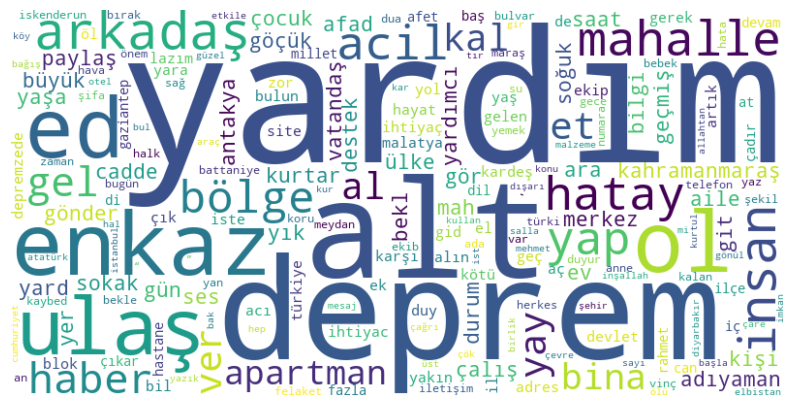

In [35]:
all_words = []
df_combined["content_wo_lemmatized"] = df_combined["content_wo_lemmatized"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
for text in df_combined["content_wo_lemmatized"]:
    all_words.extend(text)

word_counts = Counter(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df.head()

,timestamp,username,handle,tweet_date,content,content_ment_link,content_wo_punct,content_wo_removed_english,content_wo_normalize,content_wo_tokenize,content_wo_stop,content_wo_lemmatized,content_no_rare_words
0,2024-11-03 19:38:25,Orhan Şevik,orhan_sevik,"Feb 8, 2023",@haluklevent\n @oguzhanugur\n hepinizden alla...,\n \n hepinizden allah razı olsun iyiki varsı...,hepinizden allah razı olsun iyiki varsını...,hepinizden allah razı olsun iyiki varsınız deprem,hepinizden allah razı olsun iyi ki varsınız de...,"[hepinizden, allah, razı, olsun, iyi, ki, vars...","[hepinizden, razı, varsınız, deprem]","[hep, razı, var, deprem]","[hep, razı, var, deprem]"
1,2024-11-03 19:38:25,nursena,nurssxx_,"Feb 8, 2023",allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver #deprem,allahım nolur sen onlara dayanma gücü ver deprem,allahım nolur onlara dayanma gücü ver deprem,allahım ne olur onlara dayanma gücü ver deprem,"[allahım, ne, olur, onlara, dayanma, gücü, ver...","[onlara, dayanma, gücü, ver, deprem]","[o, dayan, güc, ver, deprem]","[o, dayan, güc, ver, deprem]"
2,2024-11-03 19:38:25,Elif ŞEKER,55ellllllif,"Feb 8, 2023",replying to \n@haluklevent\n @danlabilic\n and...,replying to \n\n \n and \n_harun\nadıyamanda a...,replying to and harun adıyamanda ali taş...,harun adıyamanda ali taşı mahallesi sokak hic...,harun adıyamanda ali taşı mahallesi sokak hicr...,"[harun, adıyamanda, ali, taşı, mahallesi, soka...","[harun, adıyamanda, ali, taşı, mahallesi, soka...","[haru, adıyaman, ali, taşı, mahalle, sokak, hi...","[adıyaman, ali, taşı, mahalle, sokak, apartman..."
3,2024-11-03 19:38:25,Yusuf,yusufaltuns,"Feb 8, 2023",tuğba södekoğlu kovulsun \n@showtv\n #deprem,tuğba södekoğlu kovulsun \n\n #deprem,tuğba södekoğlu kovulsun deprem,tuğba södekoğlu kovulsun deprem,tuğba sodekoğlu kovulsun deprem,"[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kovulsun, deprem]","[tuğba, sodekoğlu, kov, deprem]",[deprem]
4,2024-11-03 19:38:25,𝐎̈𝐳𝐠𝐮̈𝐫 𝐑𝐚𝐧,dryghtn2,"Feb 8, 2023",arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz\nkahramanmaraş elbis...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşimiza ulaşamiyoruz kahramanmaraş elbist...,arkadaşımıza ulaşamıyoruz kahramanmaraş elbist...,"[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaşımıza, ulaşamıyoruz, kahramanmaraş, el...","[arkadaş, ulaş, kahramanmaraş, elbistan, pınar...","[arkadaş, ulaş, kahramanmaraş, elbistan, mahal..."


In [ ]:
df.to_csv('../results/TweetAnalyzeResult.csv', index=False)